# STAT8003 Time Series Forecasting
### Topic: Electricity Consumption in UK (2009-2023)

In [1]:
!pip install pmdarima
!pip install matplotlib
!pip install scipy
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install statsmodels
!pip install xgboost
!pip install torch
!pip install scikit-learn
!pip install tqdm

  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl.metadata (10.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 652.1/652.1 kB 1.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 2.7 MB/s eta 0:00:0000:0100:01
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 3.4 MB/s eta 0:00:0000:0100:01
Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 6.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.7/146.7 MB 3.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.

In [2]:
## Define imports here
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
import seaborn as sns
import os

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from tqdm.notebook import trange, tqdm
from itertools import product


import pmdarima as pm
import xgboost as xgb

import torch
import torch.nn as nn

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [3]:
consumption_df = pd.read_csv(f"./historic_demand_2009_2023.csv", index_col=0)
consumption_df.head()

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,NaN,NaN,1


In [ ]:
## Initial data exploration to see what we are deading with

### check the shape of the data
### check the total columns
print(consumption_df.shape)
print(consumption_df.columns)

(261456, 20)
Index(['settlement_date', 'settlement_period', 'nd', 'tsd',
       'england_wales_demand', 'embedded_wind_generation',
       'embedded_wind_capacity', 'embedded_solar_generation',
       'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping',
       'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow',
       'nemo_flow', 'nsl_flow', 'eleclink_flow', 'is_holiday'],
      dtype='object')


In [ ]:
# @markdown The dataset is updated twice an hour providing us 48 entries for each day. From the printed columns above, we will keep the following columns to begin our analysis:
# @markdown 1. settlement_date
# @markdown 2. settlement_period
# @markdown 3. nd -> corresponds to national demand in MW. Sum of metered generation from UK household between 2009 - 2023. This will be our target variable which we aim to forecast ahead

In [ ]:
## Filter the data to only include the columns we need
## Update the column names to be more readable
consumption_df = consumption_df[["settlement_date", "settlement_period", "nd"]]
consumption_df.columns = ["settlement_date", "settlement_period", "national_demand"]
consumption_df.head()

,settlement_date,settlement_period,national_demand
0,2009-01-01,1,37910
1,2009-01-01,2,38047
2,2009-01-01,3,37380
3,2009-01-01,4,36426
4,2009-01-01,5,35687


In [ ]:
## We check for missing values
consumption_df.isnull().sum()

settlement_date      0
settlement_period    0
national_demand      0
dtype: int64

In [ ]:
## Since no missing values, we can proceed to check if all settlement periods are present
## We expect 48 settlement periods per day
consumption_df.groupby("settlement_date").count()["settlement_period"].unique()

array([48, 46, 50])

In [ ]:
## We see that some of the days have 46 recrods while some have 50 records
## lets find how many of these days are there

consumption_df.groupby("settlement_date").count()["settlement_period"].value_counts()

48    5417
46      15
50      15
Name: settlement_period, dtype: int64

In [ ]:
## we see that there are 15 days with 46 records and 14 days with 50 records
## this seems substaniol enough to warrant further investigation.
## find the dates with 46 records and observe the data
for _, df in consumption_df.groupby("settlement_date"):
    if df.shape[0] == 46:
        print(df)

     settlement_date  settlement_period  national_demand
4176      2009-03-29                  1            32556
4177      2009-03-29                  2            32334
4178      2009-03-29                  3            31983
4179      2009-03-29                  4            31605
4180      2009-03-29                  5            31235
4181      2009-03-29                  6            30769
4182      2009-03-29                  7            29946
4183      2009-03-29                  8            29191
4184      2009-03-29                  9            28661
4185      2009-03-29                 10            28453
4186      2009-03-29                 11            28674
4187      2009-03-29                 12            28465
4188      2009-03-29                 13            28989
4189      2009-03-29                 14            29706
4190      2009-03-29                 15            30567
4191      2009-03-29                 16            31462
4192      2009-03-29           

In [ ]:
## lets check the days with 50 records and observe the data
for _, df in consumption_df.groupby("settlement_date"):
    if df.shape[0] == 50:
        print(df)

      settlement_date  settlement_period  national_demand
14254      2009-10-25                  1            26115
14255      2009-10-25                  2            24948
14256      2009-10-25                  3            25518
14257      2009-10-25                  4            25647
14258      2009-10-25                  5            24972
14259      2009-10-25                  6            24308
14260      2009-10-25                  7            23652
14261      2009-10-25                  8            23370
14262      2009-10-25                  9            22860
14263      2009-10-25                 10            22397
14264      2009-10-25                 11            22159
14265      2009-10-25                 12            22154
14266      2009-10-25                 13            22336
14267      2009-10-25                 14            22744
14268      2009-10-25                 15            23820
14269      2009-10-25                 16            24325
14270      200

In [ ]:
## for dates with 46 records, it seems like that the log for some hour was not recorded
## for dates with 50 records, it seems like that we had extra logs. there's no consecutive
## repition and since to time log is recorded, we can't tell which one is the correct one

## one pattern we see is there is a 2 day cycle of 46 and 50 records for each year
## hence, there shouldn't be much of an issue if we drop these days
## lets drop these days and check the shape of the data

## it is believed the missing hours and extra hour logs is due to day light saving
## https://www.timeanddate.com/time/change/uk?year=2009

for _, df in consumption_df.groupby("settlement_date"):
    if df.shape[0] == 46 or df.shape[0] == 50:
        consumption_df.drop(df.index, inplace=True)
print(consumption_df.shape)

(260016, 3)


In [ ]:
## check if the all the rows with 46 and 50 rows are removed
original_shape = 261456
new_shape = consumption_df.shape[0]

diff_rows = original_shape - new_shape


<Axes: xlabel='national_demand', ylabel='Count'>

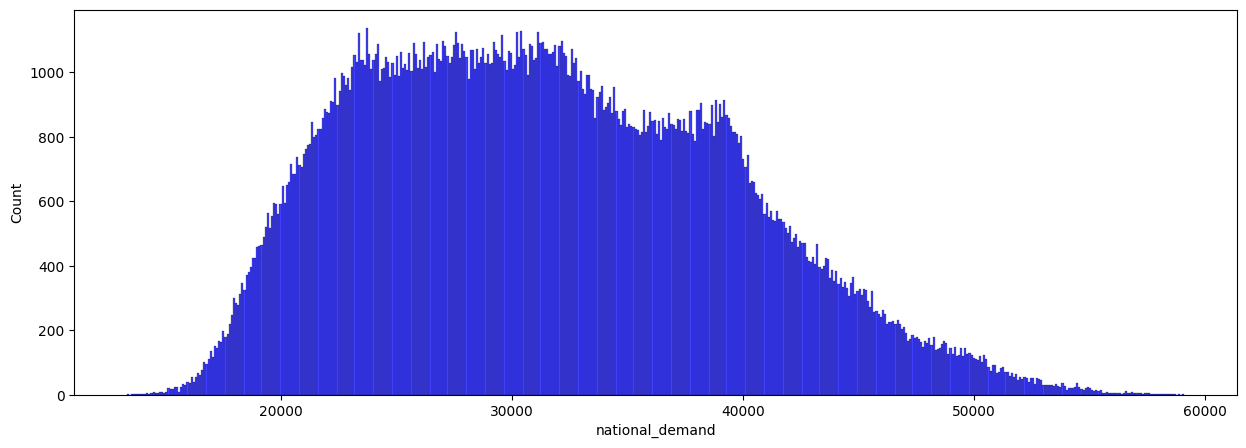

In [ ]:
### lets have some preliminary visualizations to see how is the national demand distributed using a histogram
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=consumption_df, x="national_demand", bins=500, ax=ax, color="b")


In [ ]:
# @markdown From the diagram above, it looks like that the overall distribution of national demand measured every 30 min is `positively skewed` as it has a heavier tail on the right side. Since the frequency of national demand is dense around the centre, it seems like a `platykurtic` distribution.

# @markdown We will calculate the skewness and kurtosis to confirm our intuition.

In [ ]:
skewness = stats.skew(consumption_df["national_demand"].to_list(), bias=False)
skewness

0.3532607078961006

In [ ]:
kurtosis = stats.kurtosis(consumption_df["national_demand"].to_list(), bias=False, fisher=False)
kurtosis

2.48312220086542

In [ ]:
# @markdown Our intuition is correct.
# @markdown - The skewness is positive which means that the tail is on the right side of the distribution.
# @markdown - The kurtosis is less than 3 which means that the distribution is platykurtic. Also, this means that it does not produce many outliers which is good for our modelling purposes.

Text(0.5, 1.0, 'Distribution of electricity consumption with hours')

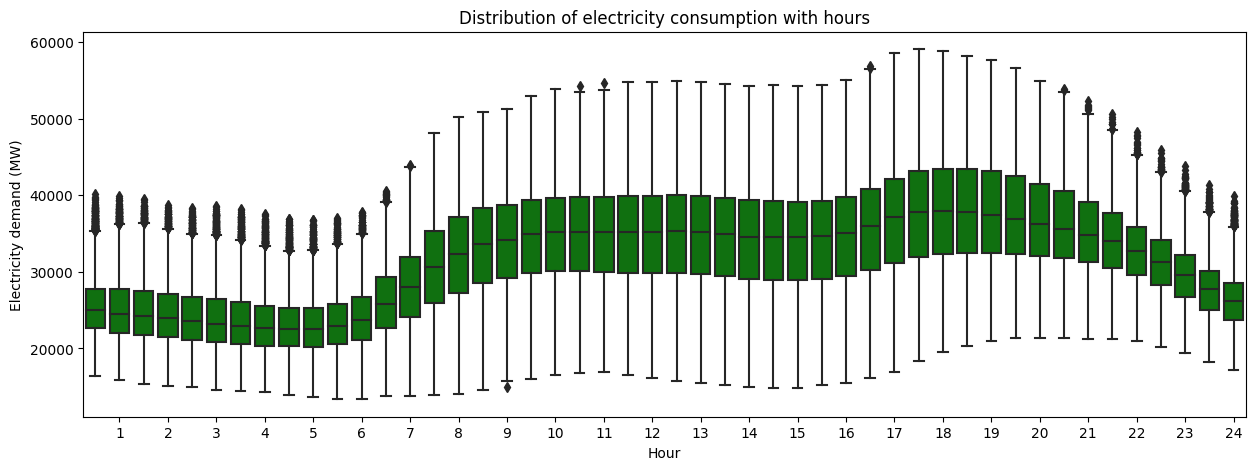

In [ ]:
## for our analysis, we'll resample the data to a weekly basis
## however, we need to aggregate the data first on a daily basis and then resample it to a weekly basis.

## for this, lets create a box plot and see how the hourly demand is distributed
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=consumption_df, x="settlement_period", y="national_demand", ax=ax, color="g")

ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours")

In [ ]:
# @markdown From here we see a pattern that hourly distribution shows higher electricity usage between 5pm - 8pm. Overall, hourly distribution seems to be fairly uniform with a few outliers. However, to not mask the affect of peak hours, we will use daily summed samples instead of mean

In [ ]:
consumption_df["settlement_date"] = pd.to_datetime(consumption_df["settlement_date"])
grouped_consumption_df = consumption_df.groupby("settlement_date")

daily_summed_national_demand = grouped_consumption_df["national_demand"].sum().reset_index()
daily_summed_national_demand.columns = ["settlement_date", "daily_summed_national_demand"]
daily_summed_national_demand

,settlement_date,daily_summed_national_demand
0,2009-01-01,1789321
1,2009-01-02,1920721
2,2009-01-03,1897691
3,2009-01-04,1911407
4,2009-01-05,2181646
...,...,...
5412,2023-11-26,1478077
5413,2023-11-27,1566696
5414,2023-11-28,1594361
5415,2023-11-29,1663923


Text(0, 0.5, 'Daily Summed Electricity demand (MW)')

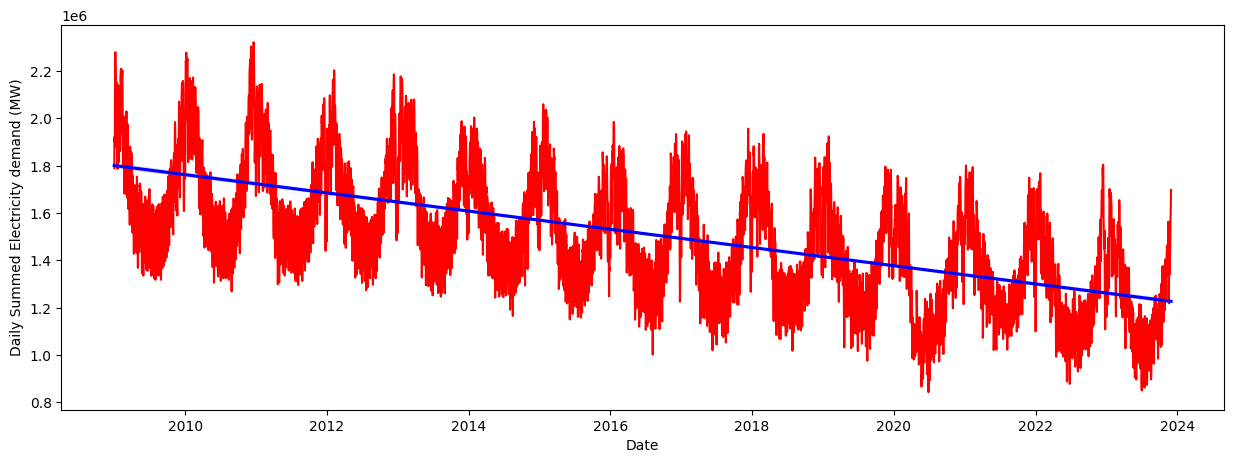

In [ ]:
### lets plot our daily mean data to see how it looks
daily_summed_national_demand['numeric_date'] = mdates.date2num(daily_summed_national_demand['settlement_date'])

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=daily_summed_national_demand, x="settlement_date", y="daily_summed_national_demand", ax=ax, color="r")

sns.regplot(data=daily_summed_national_demand, x="numeric_date", y="daily_summed_national_demand",
            ax=ax, color="b", scatter=False)

ax.set_xlabel("Date")
ax.set_ylabel("Daily Summed Electricity demand (MW)")

In [ ]:
# @markdown Interestingly, the daily naitonal demand is following a decreasing pattern. Even though, the population is increasing, this could be due to the fact that people are becoming more aware of the environmental issues and trying to reduce their carbon footprint.

# @markdown From the plot above, we can see that the national demand is following a seasonal pattern. The demand is higher during winter months and lower during summer months. This is due to the fact that people use more electricity to heat their houses during winter months.

In [ ]:
## In our forecsat, it would ge good to capture the seasonality of the data
## Hence, we can resample the data to a weekly basis and then plot it to see how it looks

# drop numeric date column. we dont need it after line graph
daily_summed_national_demand = daily_summed_national_demand.drop("numeric_date", axis=1)

weekly_summed_national_demand = daily_summed_national_demand.resample("W", on="settlement_date").sum().reset_index()
weekly_summed_national_demand.columns = ["settlement_date", "weekly_summed_national_demand"]
weekly_summed_national_demand

,settlement_date,weekly_summed_national_demand
0,2009-01-04,7519140
1,2009-01-11,15046759
2,2009-01-18,14080079
3,2009-01-25,14237170
4,2009-02-01,14246472
...,...,...
774,2023-11-05,9395589
775,2023-11-12,9851889
776,2023-11-19,9733451
777,2023-11-26,9996301


<ipython-input-109-a5803c594958>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_summed_national_demand['numeric_date'] = mdates.date2num(weekly_summed_national_demand['settlement_date'])


Text(0, 0.5, 'Weekly Summed Electricity demand (MW)')

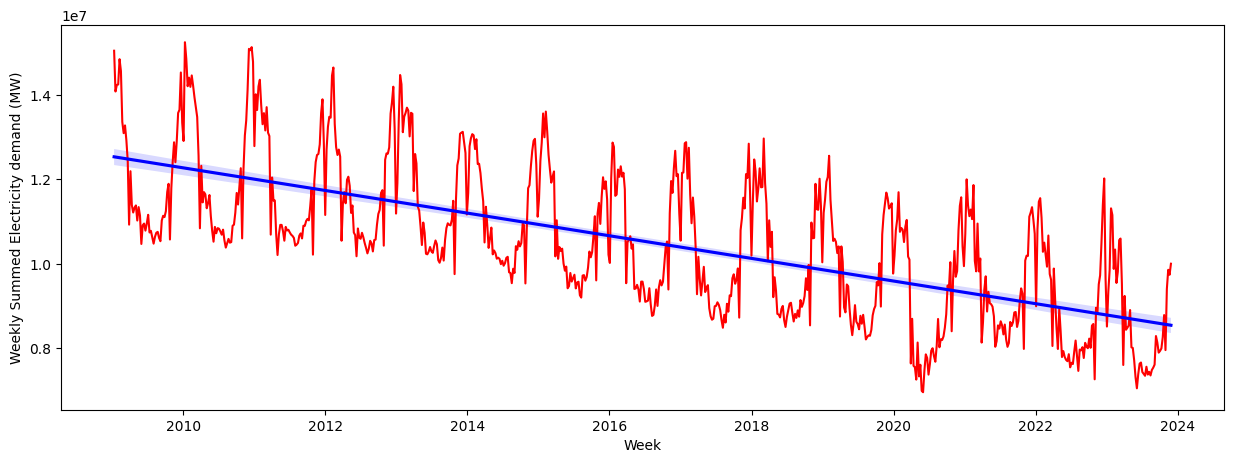

In [ ]:
## we can drop the first and last week since they are incomplete
weekly_summed_national_demand = weekly_summed_national_demand[1:-1]

## lets plot our weekly mean data to see how it looks
weekly_summed_national_demand['numeric_date'] = mdates.date2num(weekly_summed_national_demand['settlement_date'])

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=weekly_summed_national_demand, x="settlement_date", y="weekly_summed_national_demand", ax=ax, color="r")

sns.regplot(data=weekly_summed_national_demand, x="numeric_date", y="weekly_summed_national_demand",
            ax=ax, color="b", scatter=False)

ax.set_xlabel("Week")
ax.set_ylabel("Weekly Summed Electricity demand (MW)")

<ipython-input-110-ebc1121037c2>:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['settlement_date'], dtype='object')
  rolling_mean = daily_summed_national_demand.rolling(window=4).mean()


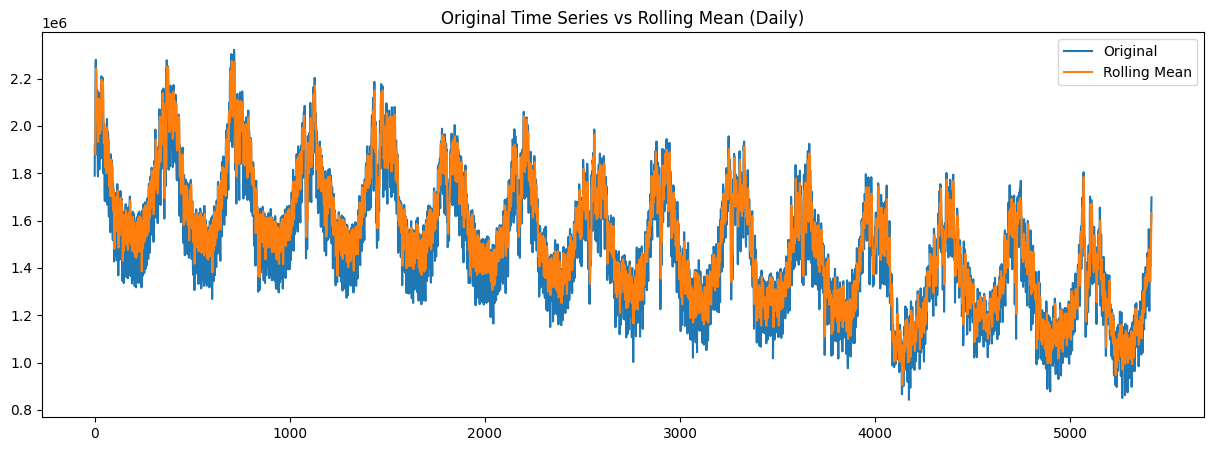

In [ ]:
# Daily
rolling_mean = daily_summed_national_demand.rolling(window=4).mean()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(daily_summed_national_demand["daily_summed_national_demand"], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.title('Original Time Series vs Rolling Mean (Daily)')
plt.legend()
plt.show()

<ipython-input-111-f2c351a78228>:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['settlement_date'], dtype='object')
  rolling_var = daily_summed_national_demand.rolling(window=4).var()


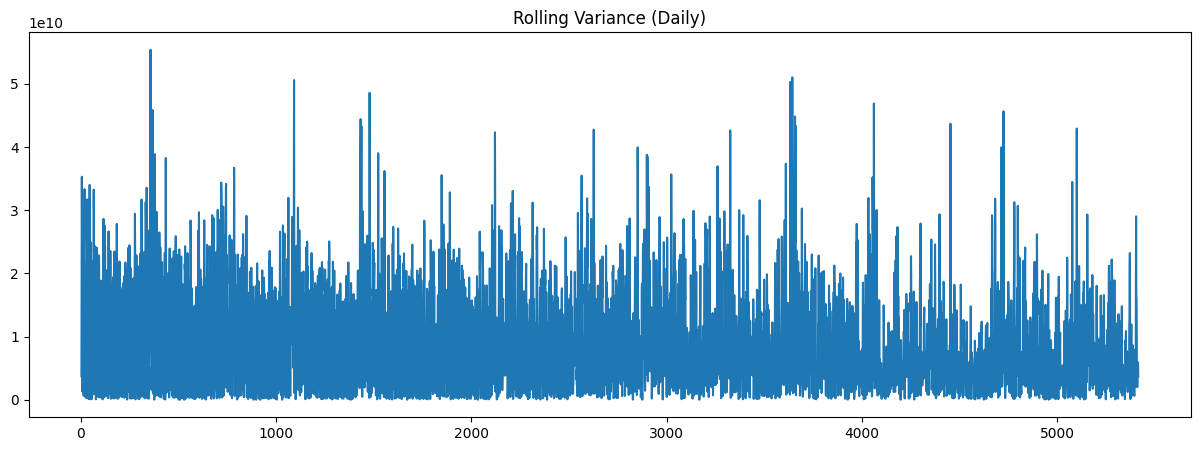

In [ ]:
rolling_var = daily_summed_national_demand.rolling(window=4).var()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(rolling_var)
plt.title('Rolling Variance (Daily)')
plt.show()

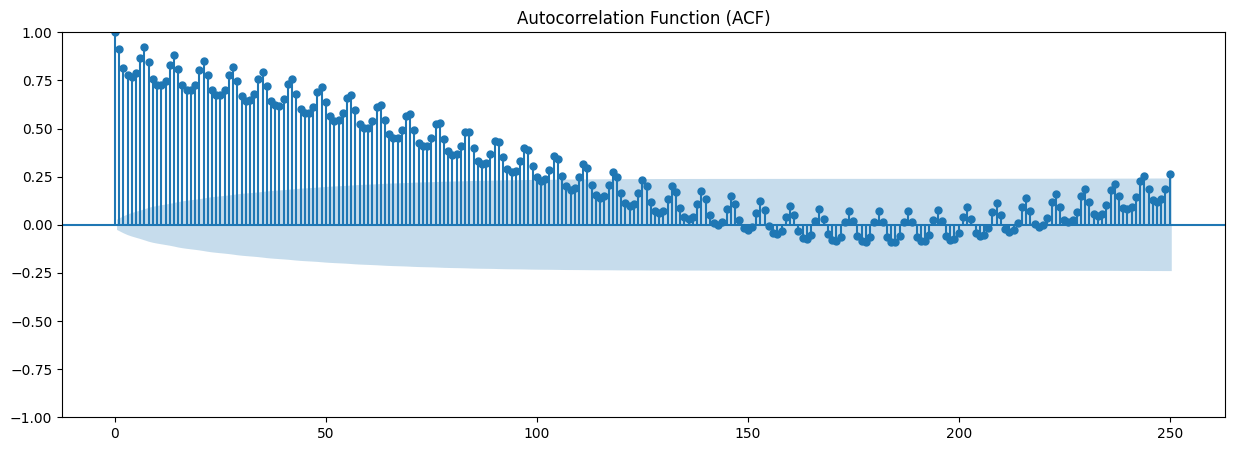

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(daily_summed_national_demand["daily_summed_national_demand"], lags=250, ax=ax)
plt.title('Autocorrelation Function (ACF)')
plt.show()

<ipython-input-113-75b1320c2937>:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['settlement_date'], dtype='object')
  rolling_mean_weekly = weekly_summed_national_demand.rolling(window=4).mean()


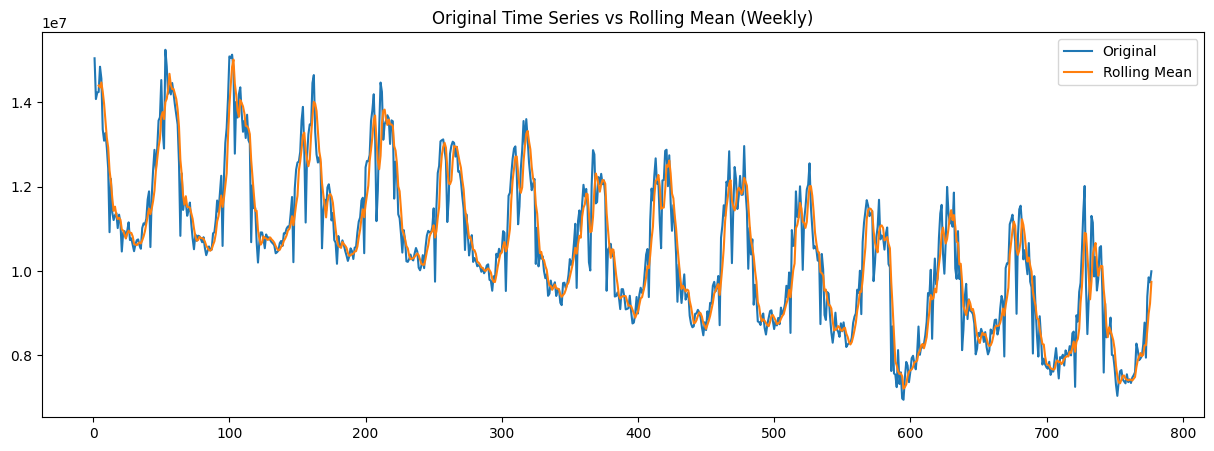

In [ ]:
# Weekly
rolling_mean_weekly = weekly_summed_national_demand.rolling(window=4).mean()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(weekly_summed_national_demand["weekly_summed_national_demand"], label='Original')
plt.plot(rolling_mean_weekly["weekly_summed_national_demand"], label='Rolling Mean')
plt.title('Original Time Series vs Rolling Mean (Weekly)')
plt.legend()
plt.show()

<ipython-input-114-0746f2180c8e>:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['settlement_date'], dtype='object')
  rolling_var_weekly = weekly_summed_national_demand.rolling(window=4).var()


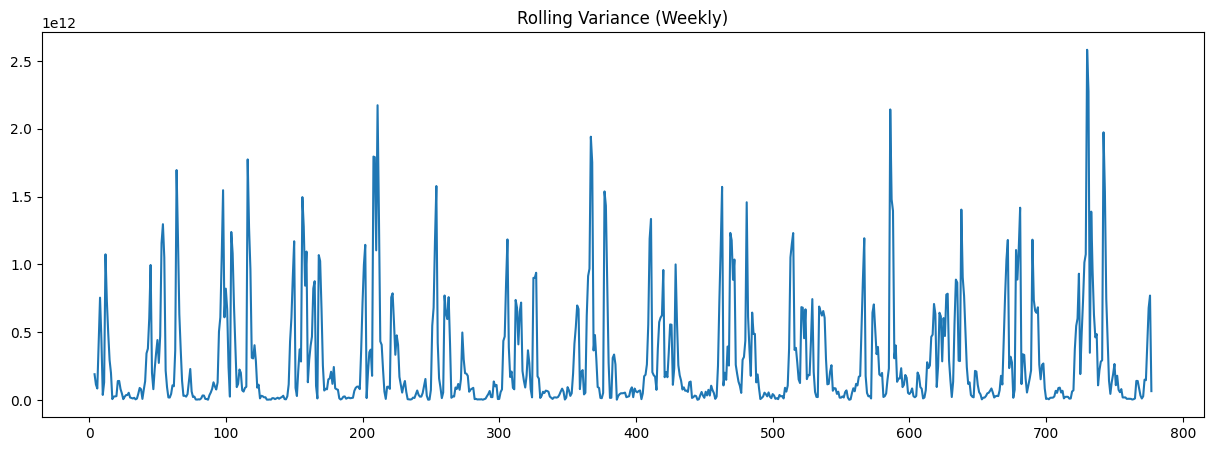

In [ ]:
rolling_var_weekly = weekly_summed_national_demand.rolling(window=4).var()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(rolling_var_weekly["weekly_summed_national_demand"])
plt.title('Rolling Variance (Weekly)')
plt.show()

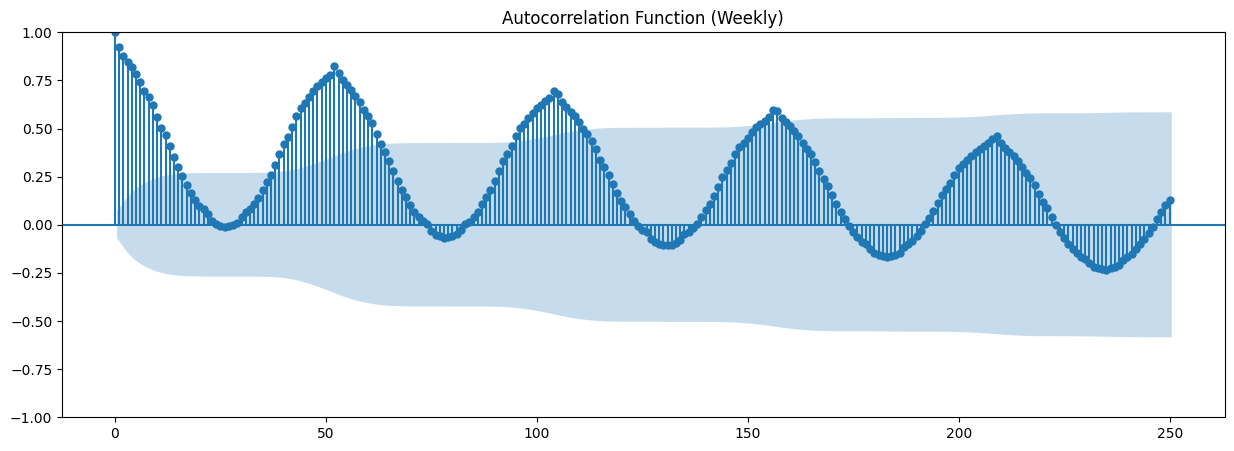

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(weekly_summed_national_demand["weekly_summed_national_demand"], lags=250, ax=ax)
plt.title('Autocorrelation Function (Weekly)')
plt.show()

From the above ACF figure, it is decaying, very slowly, and remains well above the significance range. This is indicative of a non-stationary series.Thus, it is certain that the time seris is not stationary.

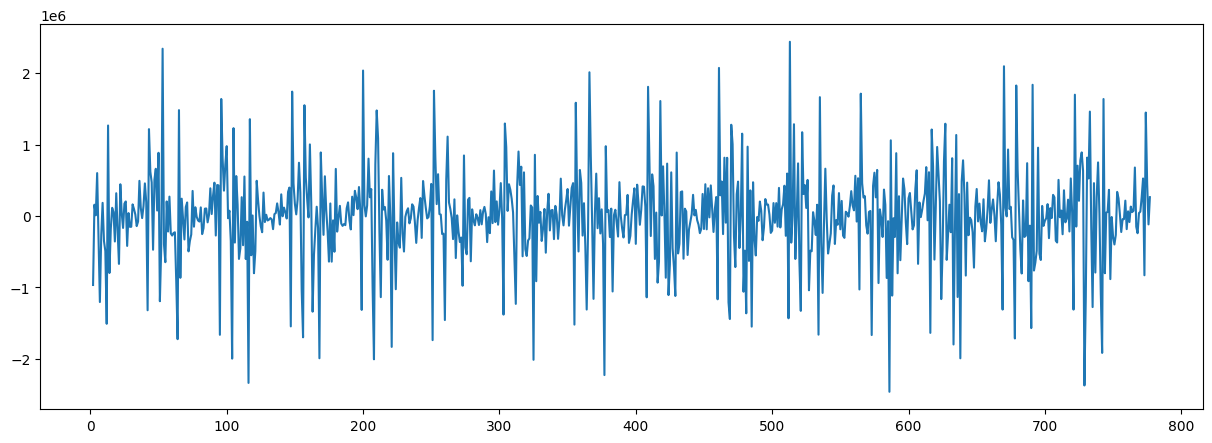

In [ ]:
# Apply differencing and check if the data is stationary
weekly_summed_national_demand_diff = weekly_summed_national_demand.diff().dropna()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(weekly_summed_national_demand_diff["weekly_summed_national_demand"])
plt.show()

From the looks of it, the mean looks stationary. We can confirm our hypothesis with an AD Fuller test. We will also plot the ACF and PACF to see if there is any trend or seasonality in our data.

In [ ]:
# Perform ADF test
result = adfuller(weekly_summed_national_demand_diff["weekly_summed_national_demand"])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')

for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.428082676752458
p-value: 1.9027158005678556e-13
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


Since the p-value is less than 0.05, we can reject the null hypothesis and say that the series is stationary. We will now plot the ACF and PACF of differenced series to decide the value of p and q.

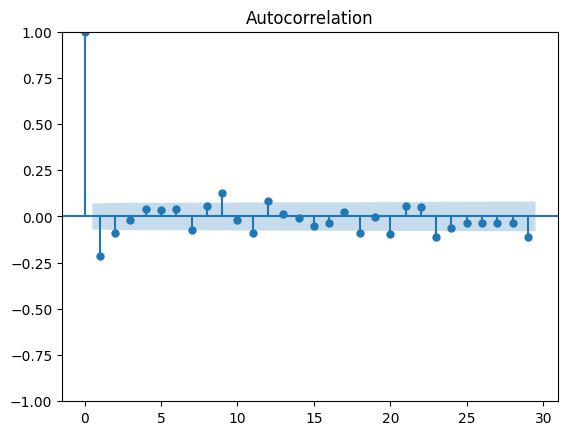

In [ ]:
plot_acf(weekly_summed_national_demand_diff["weekly_summed_national_demand"])
plt.show()

From the ACF plot above, we can determine the value of q is 2 first.

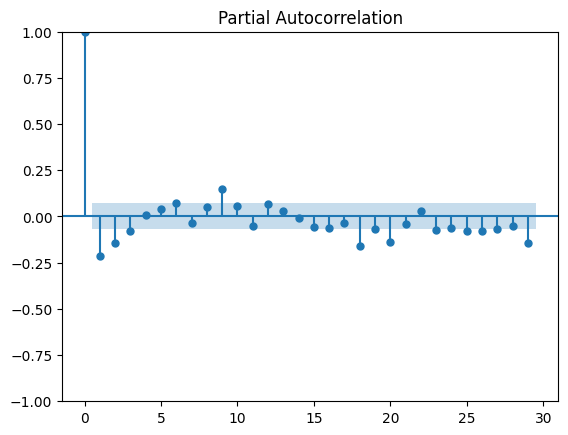

In [ ]:
plot_pacf(weekly_summed_national_demand_diff["weekly_summed_national_demand"])
plt.show()

From the PACF plot above, we can determine the value of p is 3.

After that, we need to determine the seasonality of the model by decompose the timeseries model.

Therefore, we can first assume the time series model as ARIMA(3, 1, 2) and fit these parameters to the model and do the forecasting, after that we would do the diagnostics checking of the model and use AIC to choose the best ARIMA model later on to verify our assumption.

### LOG TRANSFORMED DIFFERENCING

In [ ]:
weekly_summed_nd_diff = weekly_summed_national_demand.copy()

In [ ]:
weekly_summed_nd_diff['weekly_summed_national_demand'] = np.log(weekly_summed_nd_diff['weekly_summed_national_demand'])
weekly_summed_nd_diff['weekly_summed_national_demand'] = weekly_summed_nd_diff['weekly_summed_national_demand'].diff()
weekly_summed_nd_diff = weekly_summed_nd_diff.drop(weekly_summed_nd_diff.index[0])

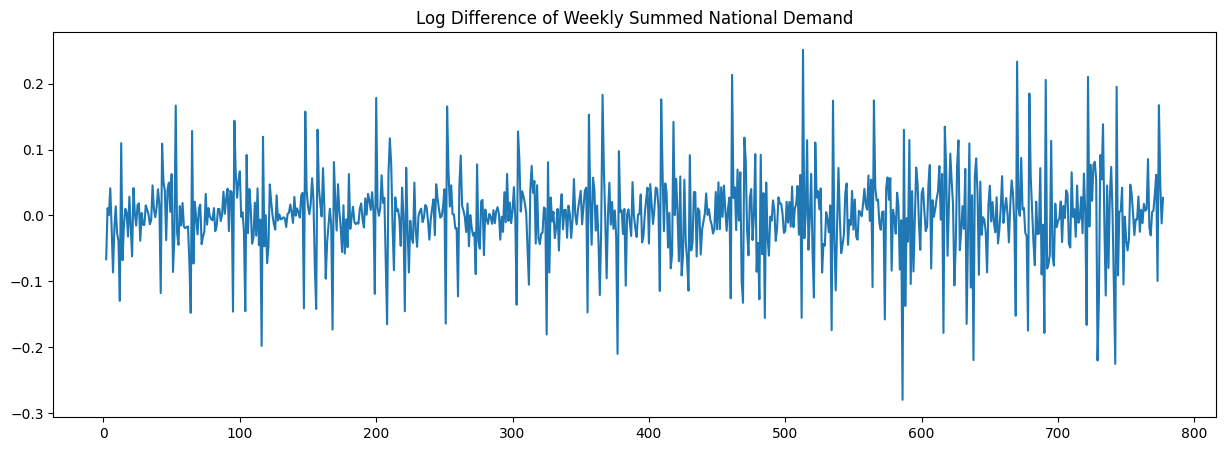

In [ ]:
plt.figure(figsize=[15, 5]); # Set dimensions for figure
plt.plot(weekly_summed_nd_diff['weekly_summed_national_demand'])
plt.title("Log Difference of Weekly Summed National Demand")
plt.show()

In [ ]:
# Perform ADF test
result = adfuller(weekly_summed_nd_diff["weekly_summed_national_demand"])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')

for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.495042456335922
p-value: 1.2826564271418795e-13
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [ ]:
# Seasonal differencing
weekly_summed_nd_diff['weekly_summed_national_demand'] = weekly_summed_nd_diff['weekly_summed_national_demand'].diff(52)
weekly_summed_nd_diff = weekly_summed_nd_diff.dropna(axis =0).reset_index(drop=True)

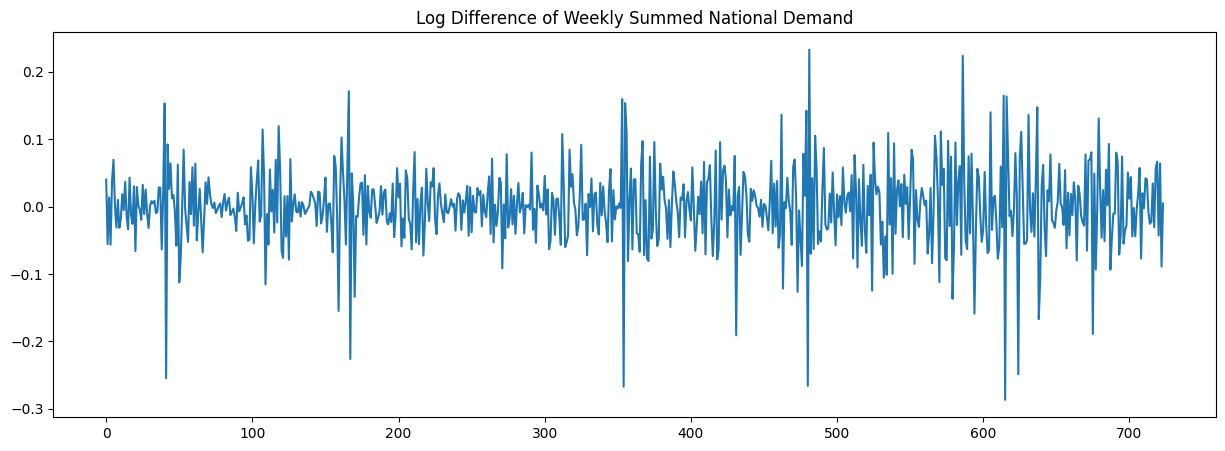

In [ ]:
plt.figure(figsize=[15, 5]); # Set dimensions for figure
plt.plot(weekly_summed_nd_diff['weekly_summed_national_demand'])
plt.title("Log Difference of Weekly Summed National Demand")
plt.show()

In [ ]:
# # Perform ADF test
result = adfuller(weekly_summed_nd_diff['weekly_summed_national_demand'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')

for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.893472987315606
p-value: 1.2246229281705395e-14
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


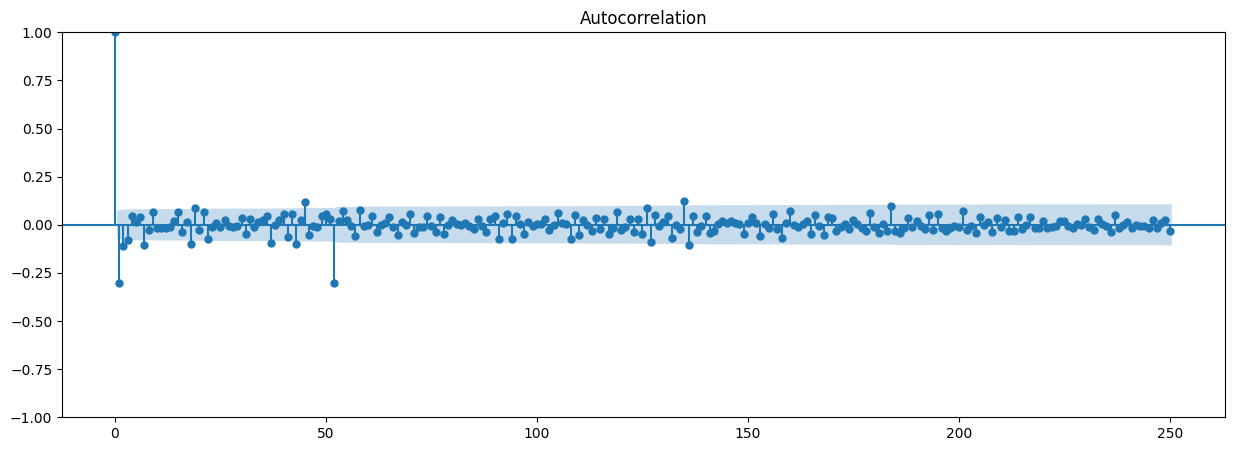

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(weekly_summed_nd_diff['weekly_summed_national_demand'].dropna(), lags = 250, ax=ax)
plt.show()

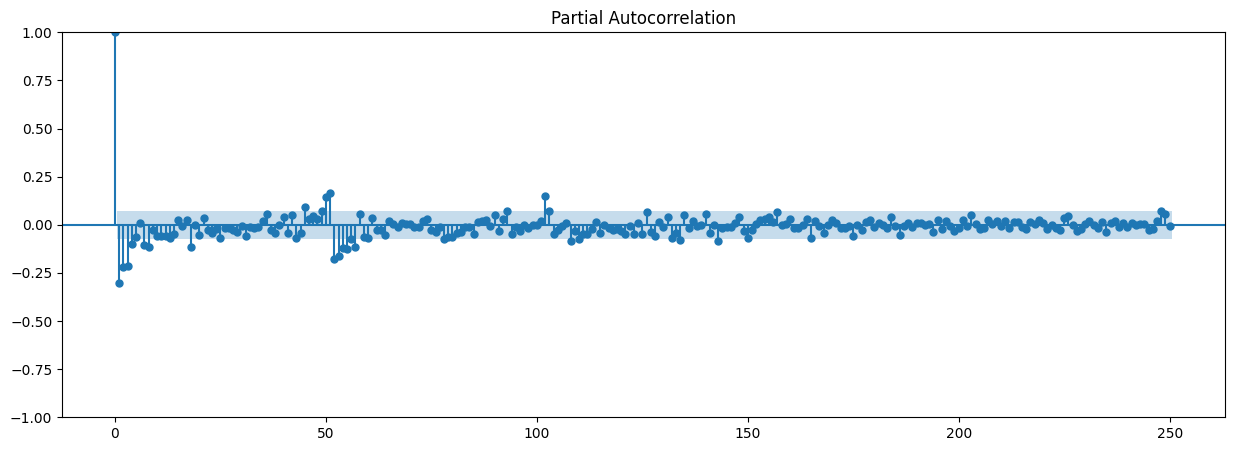

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(weekly_summed_nd_diff['weekly_summed_national_demand'].dropna(), lags = 250, ax=ax)
plt.show()

In [ ]:
weekly_df = weekly_summed_nd_diff[['settlement_date', 'weekly_summed_national_demand']]
weekly_df.set_index('settlement_date', inplace=True)
weekly_df

,weekly_summed_national_demand
settlement_date,
2010-01-17,0.040130
2010-01-24,-0.055677
2010-01-31,0.013533
2010-02-07,-0.056496
2010-02-14,0.038031
...,...
2023-10-29,0.066734
2023-11-05,-0.042902
2023-11-12,0.064178


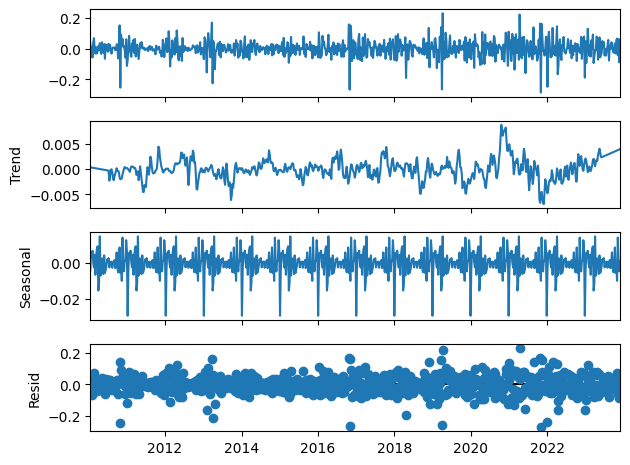

In [ ]:
weekly_season = seasonal_decompose(weekly_df, model='additive',extrapolate_trend='freq')
weekly_season.plot()
plt.show()

From the above result, we can conclude that P = 3, D = 1, Q = 2. Since we can see that it has seasonal cycle per year, so we can decide S = 52 as we are using the weekly data, and there are 52 weeks per year.

Therefore our model will be SARIMA(3,1,2)x(3,1,2)52.

### Prediction

In [ ]:
### prepare dataset for model fitting
weekly_log = weekly_summed_national_demand.copy()
weekly_log['weekly_summed_national_demand'] = np.log(weekly_log['weekly_summed_national_demand'])
weekly_log = weekly_log[['settlement_date', 'weekly_summed_national_demand']]
weekly_log.set_index('settlement_date', inplace=True)
weekly_log.head()

,weekly_summed_national_demand
settlement_date,
2009-01-11,16.526673
2009-01-18,16.460272
2009-01-25,16.471367
2009-02-01,16.472020
2009-02-08,16.513264


In order to test the prediction result, I prepared a few functions to do the result testing

In [ ]:
def print_error_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print("MSE: val={:.3f}".format(mse))
    print("RMSE: val={:.3f}".format(rmse))
    print("MAE: val={:.3f}".format(mae))
    print("MAPE: val={:.3f}".format(mape))


In [ ]:
def model_estimation_and_ljungboxTest(sarima_model, m):
    print(sarima_model.summary())
    l =[]
    lb_stat = []
    lb_pvalue = []
    for i in range (1,6):
      # try multiple of 10
      lag = i*10
      l.append(lag)
      lstat, lpvalue = acorr_ljungbox(sarima_model.resid, lags=[lag], return_df=True).iloc[0, ]
      lb_stat.append(lstat)
      lb_pvalue.append(lpvalue)
      # try multiple of years
      lag = i*m
      l.append(lag)
      lstat, lpvalue = acorr_ljungbox(sarima_model.resid, lags=[lag], return_df=True).iloc[0, ]
      lb_stat.append(lstat)
      lb_pvalue.append(lpvalue)

    return pd.DataFrame(list(zip(l, lb_stat, lb_pvalue)), columns = ["lags", "lb_stat", "lb_pvalue"]).sort_values("lags")

def stats_test(sar_model):
    """
    Perform statistical tests on SARIMA model and print the results

    Args:
        - sar_model: SARIMA model
    """

    # create and run statistical tests on model
    norm_val, norm_p, skew, kurtosis = sar_model.test_normality("jarquebera")[0]
    lb_val, lb_p = sar_model.test_serial_correlation(
        method="ljungbox",
    )[0]
    het_val, het_p = sar_model.test_heteroskedasticity("breakvar")[0]

    # we want to look at largest lag for Ljung-Box, so take largest number in series
    # there's intelligence in the method to determine how many lags back to calculate this stat
    lb_val = lb_val[-1]
    lb_p = lb_p[-1]
    # durbin_watson = statsmodels.stats.stattools.durbin_watson(|
    #     sar_model.filter_results.standardized_forecasts_error[
    #         0, sar_model.loglikelihood_burn :
    #     ]
    # )

    aic_val = sar_model.aic

    print(model_estimation_and_ljungboxTest(sar_model, 52))

    print("Normality: val={:.3f}, p={:.3f}".format(norm_val, norm_p))
    print("Ljung-Box: val={:.3f}, p={:.3f}".format(lb_val, lb_p))
    print("Heteroskedasticity: val={:.3f}, p={:.3f}".format(het_val, het_p))
    print("AIC: val={:3f}".format(aic_val))


def create_predict_analyse(
    timeseries, order, seasonal_order, max_iter, lags, disp_flag
):
    """
    Create SARIMA model and perform the following actions:
        - Perform statisticals tests to check if the model parameters are right
        - Plot model diagnostics
    Args:
        - timeseries: time series data
        - order: SARIMA order parameters
        - seasonal_order: SARIMA seasonal order parameters
        - max_iter: maximum number of iterations to compute SARIMA values
        - lags: number of lags used for model diagnostics
        - disp_flag: boolean variable to display SARIMA model iterations

    Returns:
        - execution_time: SARIMA model runtime
        - sarima_model: SARIMA model created using the function arguments
    """

    # Create and fit SARIMA model
    start_time = datetime.datetime.now()
    sarima_model = SARIMAX(
        timeseries, order=order, seasonal_order=seasonal_order
    ).fit(maxiter=max_iter, disp=disp_flag)
    execution_time = datetime.datetime.now() - start_time

    # Plot SARIMA model diagnostics
    sarima_model.plot_diagnostics(
        lags=lags,
        figsize=(20, 12),
    )

    # Perform statistical tests on model
    print("-------------------------------------------------------------")
    stats_test(sarima_model)
    print("execution time: val=" + str(execution_time))
    print("-------------------------------------------------------------")

    return execution_time, sarima_model

def predict_model(
    sarima_model, test_data, test_start_date
):
    """
    Predict SARIMA model and perform the following actions:
        - Predict on test data
        - Compute MAPE
        - Plot test data, prediction and confidence interval

    Args:
        - sarima_model: model
        - test_data: dataset for testing
        - test_start_date: start date

    Returns:
        - execution_time: SARIMA model runtime
        - mape: MAPE on test data
    """
    start_time = datetime.datetime.now()
    # Predict on test data
    predict = sarima_model.get_prediction(
        start=test_start_date, end=str(test_data.index[-1].date())
    )
    confidence_int = predict.conf_int(alpha=0.05)
    prediction = predict.predicted_mean

    # Calculate test data error metrics
    print_error_metrics(test_data.values, prediction.values)
    #mape = mean_absolute_percentage_error(test_data.values, prediction.values)

    # Plot test data, predictions and confidence interval
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(prediction, label="Prediction")
    ax.plot(test_data, label="Test data")
    ax.fill_between(
        confidence_int.index,
        confidence_int["lower weekly_summed_national_demand"],
        confidence_int["upper weekly_summed_national_demand"],
        alpha=0.3,
    )
    ax.set_title("Prediction on test data")
    ax.set_ylabel("Total power consumption (MW)")
    ax.legend()
    execution_time = datetime.datetime.now() - start_time

    print("-------------------------------------------------------------")
    print("mean absolute percentage error: val={:.3f}".format(mape))
    print("execution time: val=" + str(execution_time))
    print("-------------------------------------------------------------")
    return execution_time, mape, prediction, confidence_int

In [ ]:
def extract_last_pred(test_data, prediction, ci):
    """
    Extract the last 5 prediction result and calculate the exponential value
        - Extract last 5 values
        - Calculate exponential value to remove the log transformed

    Args:
        - test_data: dataset for testing
        - prediction: prediction result

    Returns:
        - prediction_df: dataframe containing the actual and prediction values
    """

    pred_data = []
    for k, v in test_data[-5:].items():
      actual_data = round(np.exp(v), 0)
      prediction_data = round(np.exp(prediction[k]), 0)
      ci_lower = round(np.exp(ci.loc[k][0]), 0)
      ci_upper = round(np.exp(ci.loc[k][1]), 0)
      pred_data.append([k,actual_data,prediction_data, ci_lower, ci_upper])

    pred_data_df = pd.DataFrame(pred_data, columns=['settlement_date', 'Actual', 'Prediction', 'Lower CI', "Upper CI" ])
    return pred_data_df

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """

    results = []

    for param in tqdm(parameters_list):
        try:
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
threshold_date = "01-01-2021"
train_data = weekly_log.loc[weekly_log.index < threshold_date, "weekly_summed_national_demand"]
test_data = weekly_log.loc[weekly_log.index >= threshold_date, "weekly_summed_national_demand"]

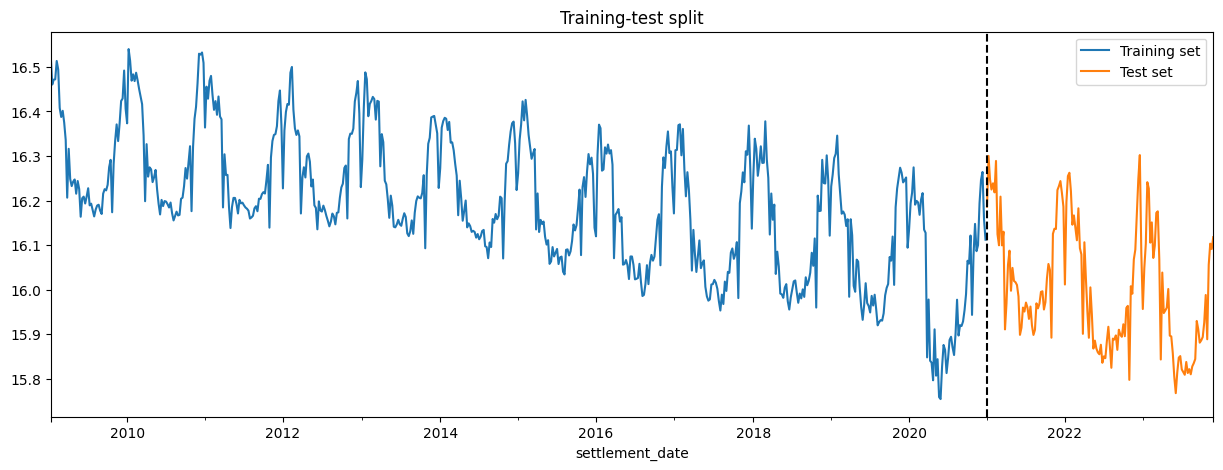

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label="Training set")
test_data.plot(ax=ax, label="Test set")
ax.axvline(threshold_date, color="k", ls="--")
ax.set_title("Training-test split")
plt.legend();

In [ ]:
p = range(2, 4, 1)
d = 1
q = range(2, 4, 1)
P = range(2, 4, 1)
D = 1
Q = range(2, 4, 1)
s = parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(parameters_list)

[(2, 2, 2, 2), (2, 2, 2, 3), (2, 2, 3, 2), (2, 2, 3, 3), (2, 3, 2, 2), (2, 3, 2, 3), (2, 3, 3, 2), (2, 3, 3, 3), (3, 2, 2, 2), (3, 2, 2, 3), (3, 2, 3, 2), (3, 2, 3, 3), (3, 3, 2, 2), (3, 3, 2, 3), (3, 3, 3, 2), (3, 3, 3, 3)]


In [ ]:
parameters_list[2:4]

[(2, 2, 3, 2), (2, 2, 3, 3)]

In [ ]:
result_df = optimize_SARIMA(parameters_list[:2], 1, 1, 52, train_data)
result_df

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood

,"(p,q)x(P,Q)",AIC
0,"(2, 2, 2, 2)",-1953.727171
1,"(2, 2, 2, 3)",-1952.251420


In [ ]:
result_df2 = optimize_SARIMA(parameters_list[2:4], 1, 1, 52, train_data)

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood

In [ ]:
result_df2

,"(p,q)x(P,Q)",AIC
0,"(2, 2, 3, 2)",-1952.379857
1,"(2, 2, 3, 3)",-1950.669704


In [ ]:
result_df3 = optimize_SARIMA([(3,3,3,2)], 1, 1, 52, train_data)
result_df3

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)x(P,Q)",AIC
0,"(3, 3, 3, 2)",-1968.147209


#### AIC Test result
We have tried 5 alternative models, among them, the best Model SARIMA(2,1,2)(3,1,3)52 has the lowest AIC and we'll use this as the best model. We'll use this to compare with our estimated model

Split the dataset into trainning and testing dataset by date

### Model fitting and forecasting

###Base Mode: SARIMA(3,1,2)x(3,1,2)52

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood

-------------------------------------------------------------
                                     SARIMAX Results                                      
Dep. Variable:      weekly_summed_national_demand   No. Observations:                  625
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 52)   Log Likelihood                 990.904
Date:                            Sun, 31 Dec 2023   AIC                          -1959.808
Time:                                    06:57:48   BIC                          -1911.967
Sample:                                01-11-2009   HQIC                         -1941.145
                                     - 12-27-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4578      1.358     -0.337      0.7

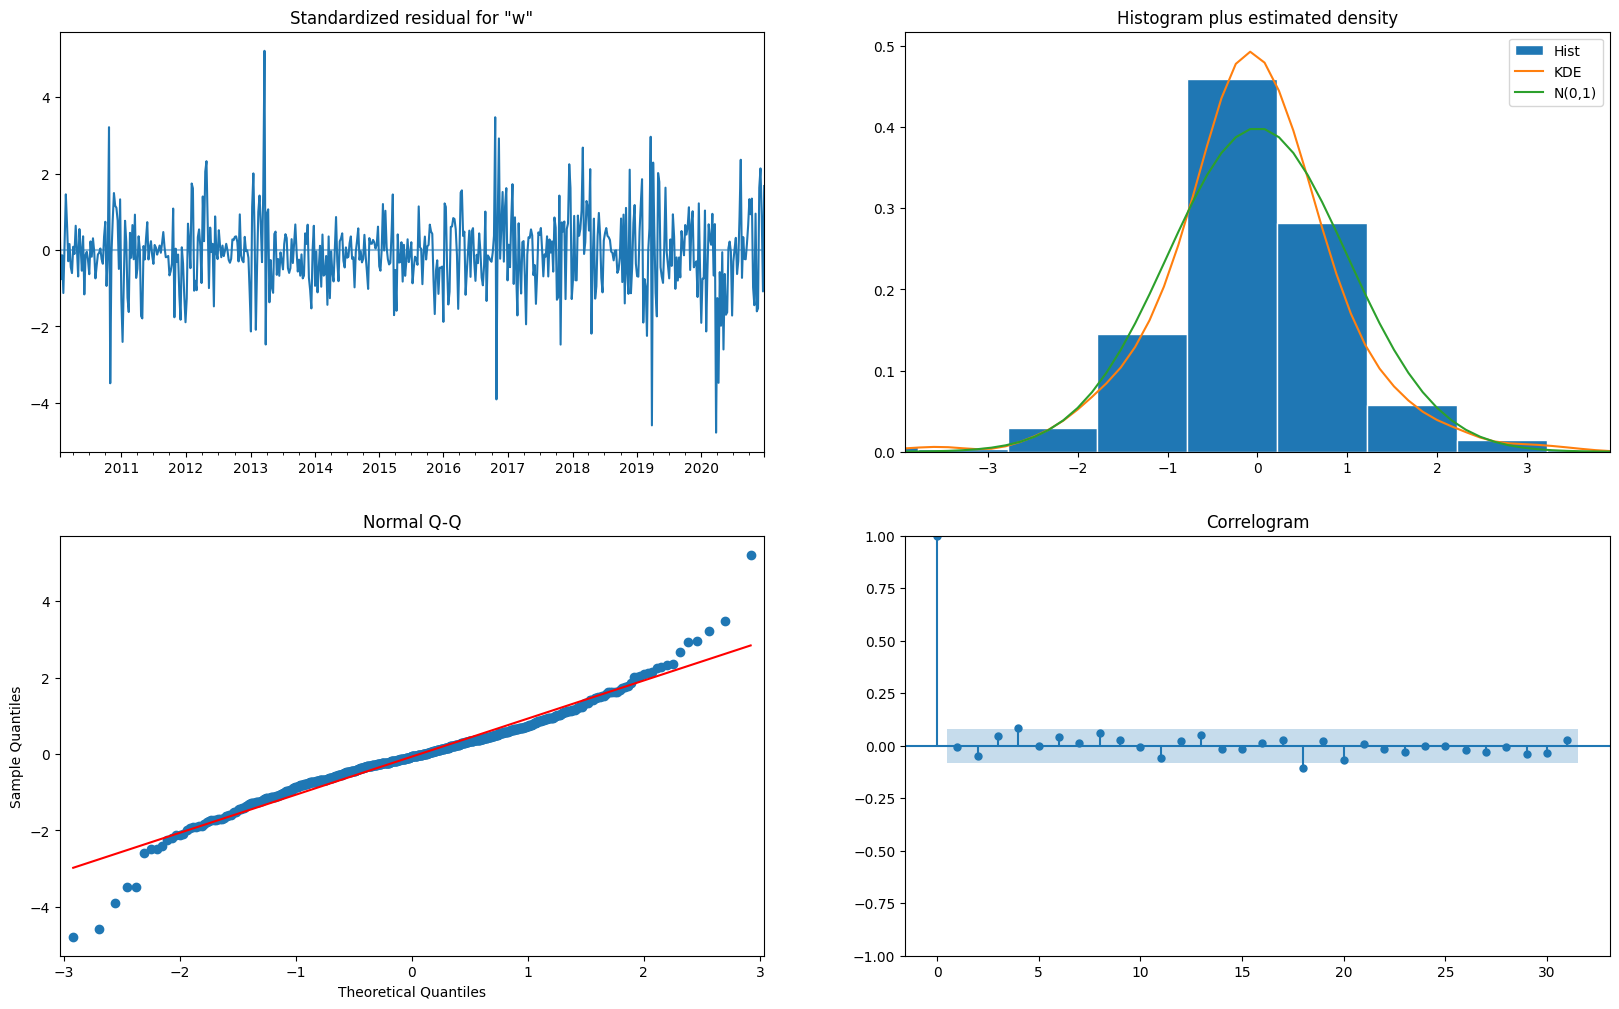

In [ ]:
[execution_time_1, sarima_model_1] = create_predict_analyse(train_data, (3, 1, 2), (3, 1, 2, 52), 75, 31, False)

MSE: val=0.009
RMSE: val=0.097
MAE: val=0.080
MAPE: val=0.503
-------------------------------------------------------------
mean absolute percentage error: val=0.503
execution time: val=0:00:00.546118
-------------------------------------------------------------


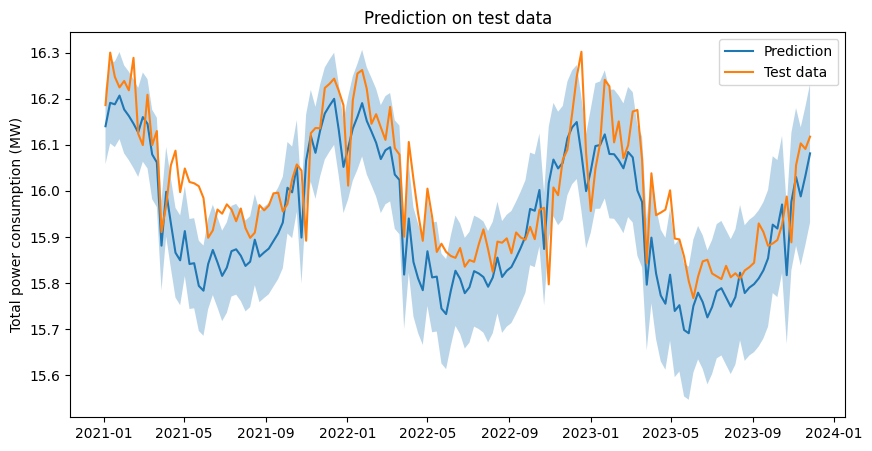

In [ ]:
[execution_time, mape, predition_1, ci1] = predict_model(sarima_model_1, test_data, threshold_date)

### Best Alternative Model: SARIMA(3,1,3)(3,1,2)52

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-------------------------------------------------------------
                                        SARIMAX Results                                        
Dep. Variable:           weekly_summed_national_demand   No. Observations:                  625
Model:             SARIMAX(3, 1, 3)x(3, 1, [1, 2], 52)   Log Likelihood                 996.674
Date:                                 Sun, 31 Dec 2023   AIC                          -1969.347
Time:                                         05:54:56   BIC                          -1917.157
Sample:                                     01-11-2009   HQIC                         -1948.987
                                          - 12-27-2020                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       

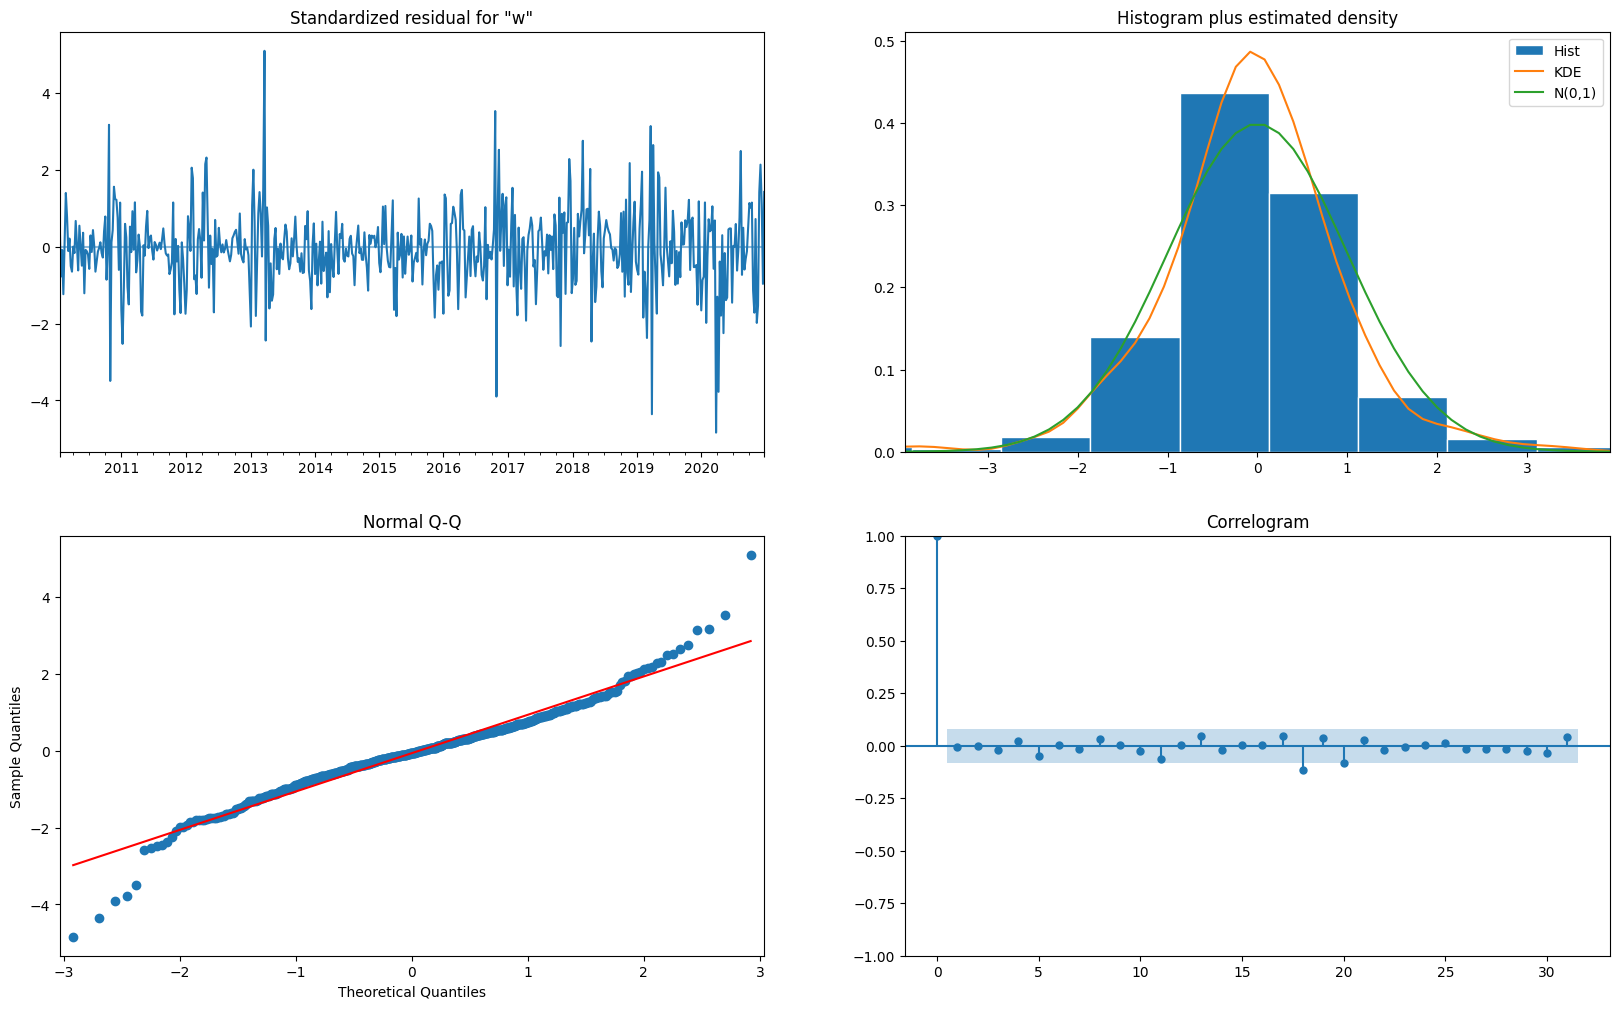

In [ ]:
#SARIMA(3,1,3)(3,1,2)52
[execution_time_2, sarima_model_2] = create_predict_analyse(train_data, (3, 1, 3), (3, 1, 2, 52), 75, 31, False)

MSE: val=0.007
RMSE: val=0.086
MAE: val=0.069
MAPE: val=0.430
-------------------------------------------------------------
mean absolute percentage error: val=0.503
execution time: val=0:00:00.510784
-------------------------------------------------------------


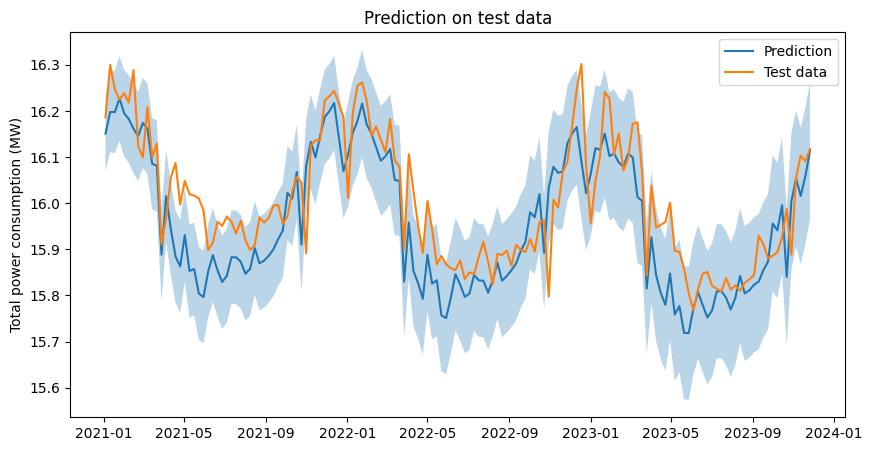

In [ ]:
[execution_time, mape, predition_2, ci2] = predict_model(sarima_model_2, test_data, threshold_date)

## Extract the last 5 predictions
After fitting with the training dataset, it is shown that our estimate model (SARIMA(3, 1, 3), (3, 1, 2, 52)) perform the best. As we have log transformed our training and testing data, we need to calculate the exponential value to cancel the log transform

In [ ]:
extract_last_pred(test_data, predition_2, ci2)

,settlement_date,Actual,Prediction,Lower CI,Upper CI
0,2023-10-29,7947981.0,8921280.0,7696101.0,10341500.0
1,2023-11-05,9395589.0,9375823.0,8087013.0,10870027.0
2,2023-11-12,9851889.0,9027470.0,7785656.0,10467353.0
3,2023-11-19,9733451.0,9425768.0,8127961.0,10930797.0
4,2023-11-26,9996301.0,9960443.0,8588049.0,11552150.0


### Prediction by Machine Learning

## XGBoost

In [ ]:
weekly_summed_national_demand_feature = weekly_summed_national_demand.copy()

In [ ]:
weekly_summed_national_demand_feature.dtypes

settlement_date                  datetime64[ns]
weekly_summed_national_demand             int64
numeric_date                            float64
dtype: object

In [ ]:
weekly_summed_national_demand_feature.head()

,settlement_date,weekly_summed_national_demand,numeric_date
1,2009-01-11,15046759,14255.0
2,2009-01-18,14080079,14262.0
3,2009-01-25,14237170,14269.0
4,2009-02-01,14246472,14276.0
5,2009-02-08,14846340,14283.0


In [ ]:
weekly_summed_national_demand_feature["quarter"] = weekly_summed_national_demand_feature['settlement_date'].dt.quarter.astype(int)
weekly_summed_national_demand_feature["month"] = weekly_summed_national_demand_feature['settlement_date'].dt.month.astype(int)
weekly_summed_national_demand_feature["year"] = weekly_summed_national_demand_feature['settlement_date'].dt.year.astype(int)
weekly_summed_national_demand_feature["week_of_year"] =  weekly_summed_national_demand_feature['settlement_date'].dt.isocalendar().week.astype(int)

In [ ]:
weekly_summed_national_demand_feature.tail()

,settlement_date,weekly_summed_national_demand,numeric_date,quarter,month,year,week_of_year
773,2023-10-29,7947981,19659.0,4,10,2023,43
774,2023-11-05,9395589,19666.0,4,11,2023,44
775,2023-11-12,9851889,19673.0,4,11,2023,45
776,2023-11-19,9733451,19680.0,4,11,2023,46
777,2023-11-26,9996301,19687.0,4,11,2023,47


In [ ]:
weekly_summed_national_demand_feature.set_index("settlement_date", inplace=True)

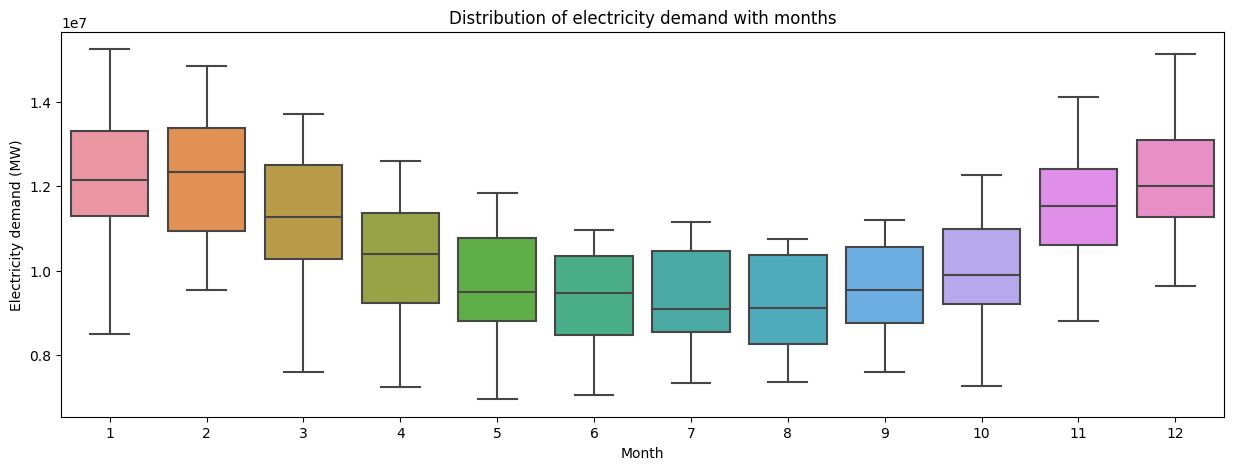

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="weekly_summed_national_demand", data=weekly_summed_national_demand_feature)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity demand with months");

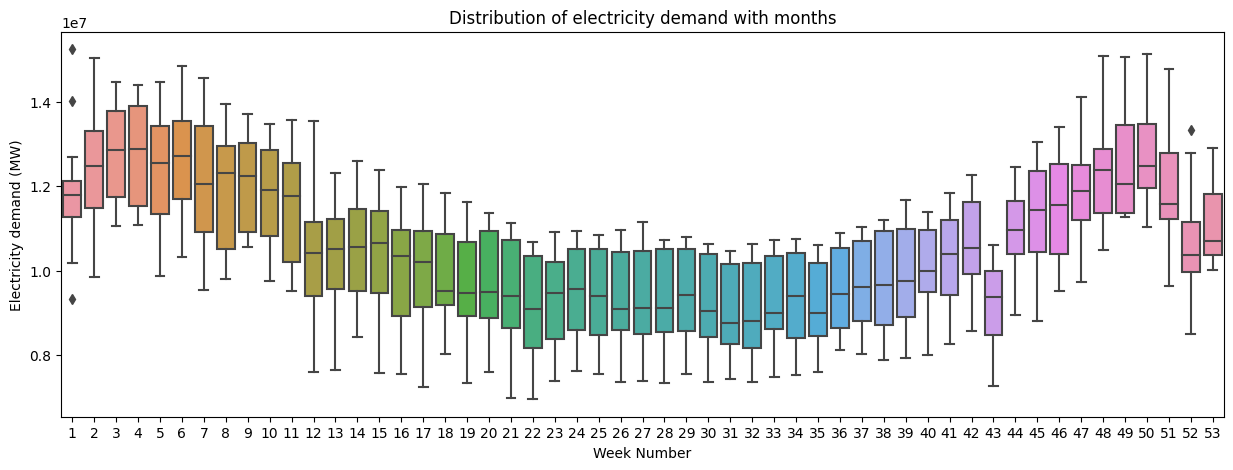

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="week_of_year", y="weekly_summed_national_demand", data=weekly_summed_national_demand_feature)

ax.set_xlabel("Week Number")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity demand with months");

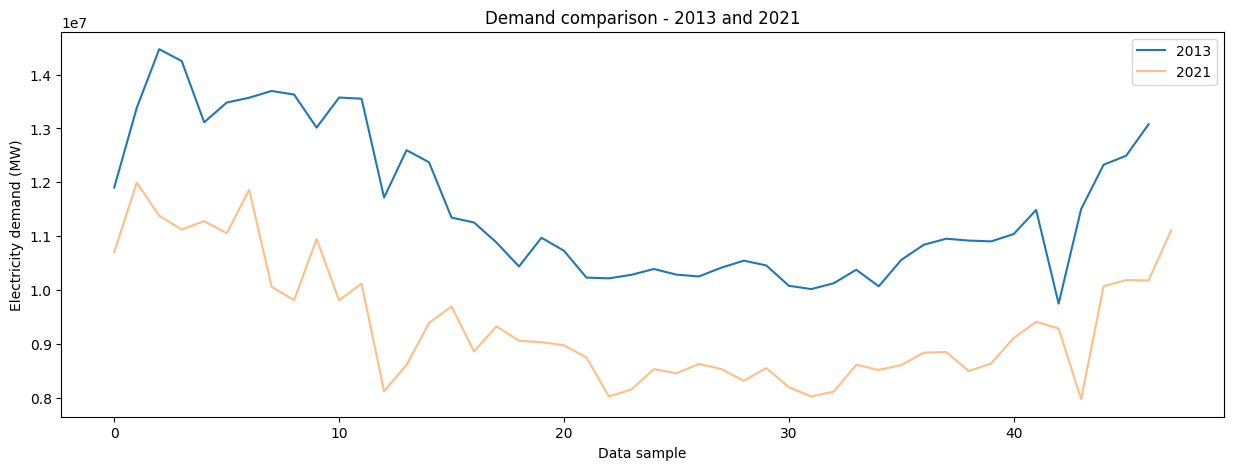

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    range(len(weekly_summed_national_demand_feature.loc[(weekly_summed_national_demand_feature.index > "01-01-2013") & (weekly_summed_national_demand_feature.index < "12-01-2013")]["weekly_summed_national_demand"])),
    weekly_summed_national_demand_feature.loc[(weekly_summed_national_demand_feature.index > "01-01-2013") & (weekly_summed_national_demand_feature.index < "12-01-2013")]["weekly_summed_national_demand"],
    label="2013",
)

ax.plot(
    range(len(weekly_summed_national_demand_feature.loc[(weekly_summed_national_demand_feature.index > "01-01-2021") & (weekly_summed_national_demand_feature.index < "12-01-2021")]["weekly_summed_national_demand"])),
    weekly_summed_national_demand_feature.loc[(weekly_summed_national_demand_feature.index > "01-01-2021") & (weekly_summed_national_demand_feature.index < "12-01-2021")]["weekly_summed_national_demand"],
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

In [ ]:
threshold_date = "01-01-2021"
train_data = weekly_summed_national_demand_feature.loc[weekly_summed_national_demand_feature.index < threshold_date]
test_data = weekly_summed_national_demand_feature.loc[weekly_summed_national_demand_feature.index >= threshold_date]

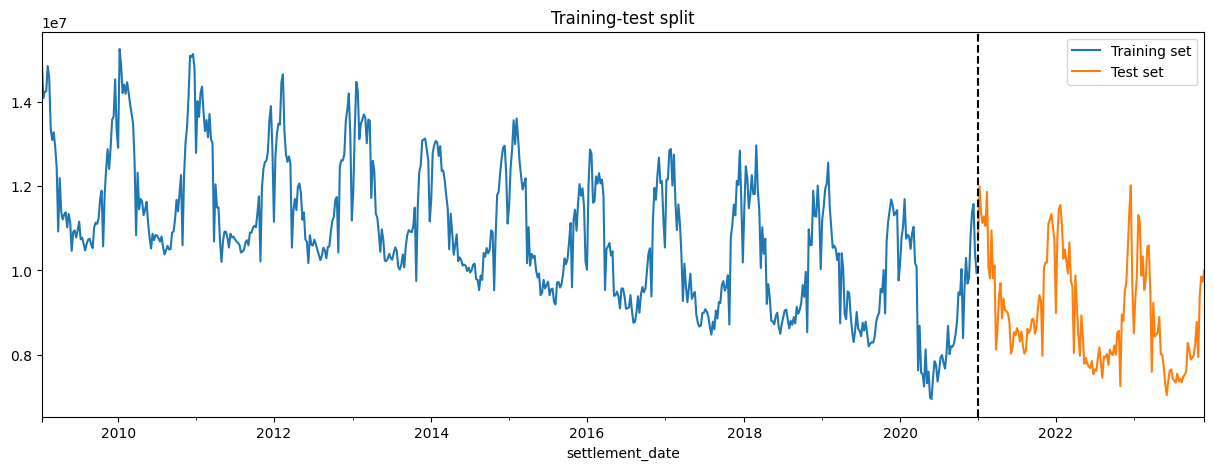

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["weekly_summed_national_demand"].plot(ax=ax, label="Training set")
test_data["weekly_summed_national_demand"].plot(ax=ax, label="Test set")
ax.axvline(threshold_date, color="k", ls="--")
ax.set_title("Training-test split")
plt.legend();

In [ ]:
# Define the features and target variable
FEATURES = [
    "numeric_date",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "weekly_summed_national_demand"

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

In [ ]:
# Initialize and fit the XGBoost model
import xgboost as xgb
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    early_stopping_rounds=50,
    random_state=43,
    enable_categorical = True
)

reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
);

[0]	validation_0-rmse:10919649.82658	validation_1-rmse:8988990.03656
[100]	validation_0-rmse:4093305.41327	validation_1-rmse:3300138.53901
[200]	validation_0-rmse:1599785.32959	validation_1-rmse:1370383.10093
[300]	validation_0-rmse:728407.18600	validation_1-rmse:918943.01385
[400]	validation_0-rmse:465262.28725	validation_1-rmse:854150.09385
[426]	validation_0-rmse:437720.99341	validation_1-rmse:861950.29194


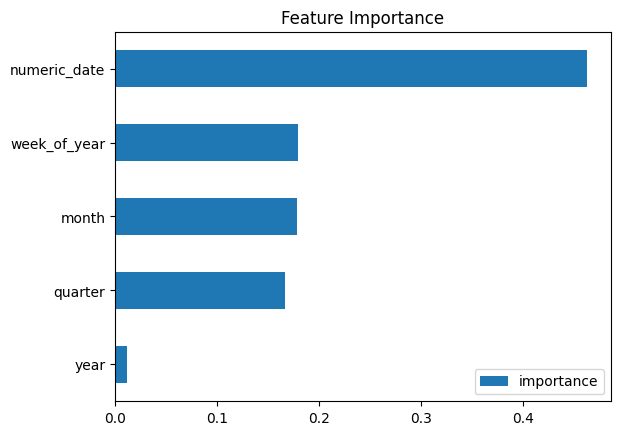

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
result_frame = y_test.to_frame()
result_frame["pred_xgb"] = reg.predict(X_test)

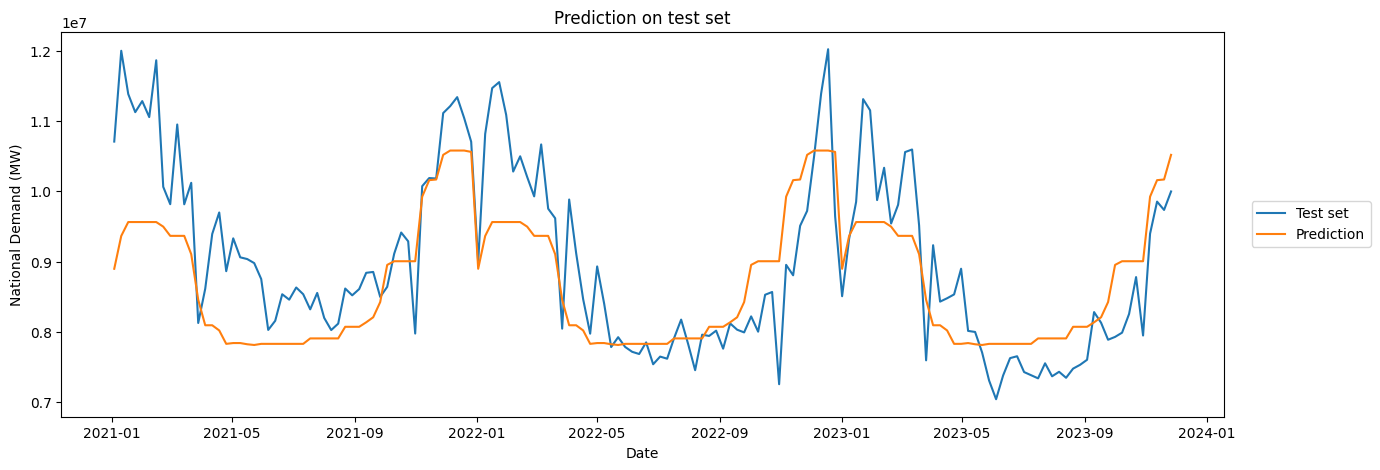

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["weekly_summed_national_demand"], label="Test set")
ax.plot(result_frame.index, result_frame["pred_xgb"], label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("National Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
print_error_metrics(result_frame["weekly_summed_national_demand"], result_frame["pred_xgb"])

MSE: val=722512625353.625
RMSE: val=850007.427
MAE: val=660788.441
MAPE: val=7.057


Apperantely, the prediction result is not good. We'll tune the pyparameters

In [ ]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500, 1000],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgb.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_


In [ ]:
hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 200,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [ ]:
xgb_model = xgb.XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.5,
        learning_rate = 0.1,
        max_depth = 3,
        min_child_weight = 5,
        n_estimators = 200,
        subsample = 0.5)

%time xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print("MAE: ", mae_xgb)

CPU times: user 256 ms, sys: 2.76 ms, total: 259 ms
Wall time: 245 ms
MAE:  558741.365131579


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [ ]:
result_frame = y_test.to_frame()
result_frame["pred_xgb"] = y_pred_xgb
result_frame

,weekly_summed_national_demand,pred_xgb
settlement_date,,
2021-01-03,10705610,9608479.0
2021-01-10,11996699,10327933.0
2021-01-17,11381575,10676035.0
2021-01-24,11123874,10750139.0
2021-01-31,11281333,10750139.0
...,...,...
2023-10-29,7947981,8880900.0
2023-11-05,9395589,10113626.0
2023-11-12,9851889,10412908.0


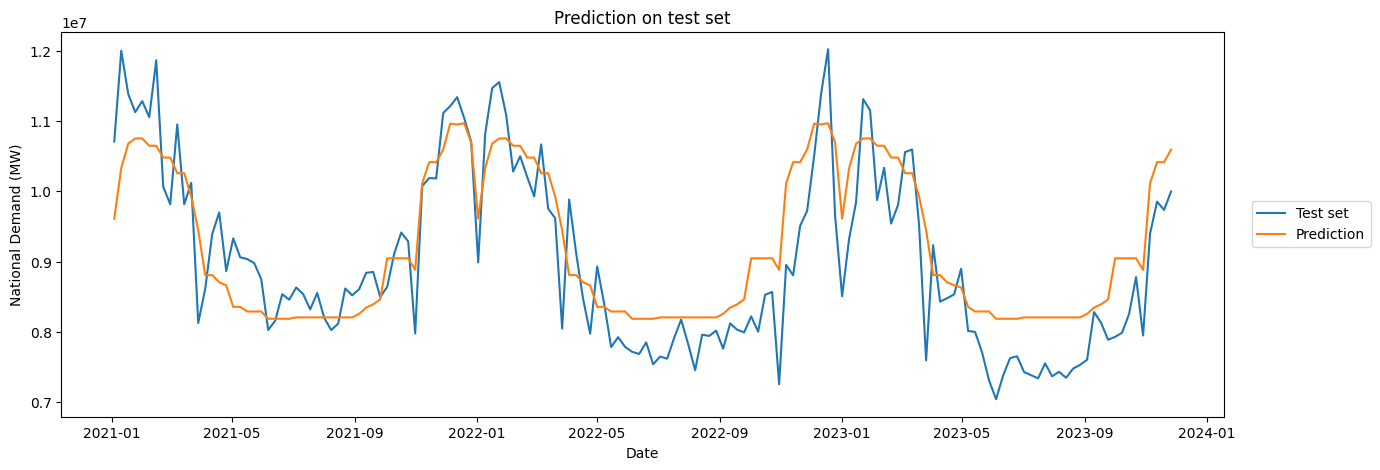

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["weekly_summed_national_demand"], label="Test set")
ax.plot(result_frame.index, result_frame["pred_xgb"], label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("National Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
print_error_metrics(result_frame["weekly_summed_national_demand"], result_frame["pred_xgb"])

MSE: val=438824831205.597
RMSE: val=662438.549
MAE: val=558741.365
MAPE: val=6.371


In [ ]:
result_frame[-5:]

,weekly_summed_national_demand,pred_xgb
settlement_date,,
2023-10-29,7947981,8880900.0
2023-11-05,9395589,10113626.0
2023-11-12,9851889,10412908.0
2023-11-19,9733451,10412908.0
2023-11-26,9996301,10592375.0


The result improved by comparing to the last prediction


# Prediction via LSTM
We will also use LSTM to predict the national demand for electricity using the weekly summed samples. Below are few reasons why LSTM is a good choice for time series forecasting:
1. Capturing Long-Term Dependencies: There are often complex and non-linear relationships in electricity demand and LSTM's memory cells enable them to retain information for longer periods of time.
2. Handling Seasonal Patterns: Electricity demands often exhibit seasonal patterns based on some features which LSTM can learn and predict features from.
3. Incorporating Additional Features. LSTM models can also incorporate additional features that may impact electricity demand, such as weather data, day of the week, holidays, or special events. By including these features as inputs to the model, the LSTM can learn the relationships between these factors and the electricity demand.

In [ ]:
# we will use weekly data for our analysis and create some new features for lstm model to predict
weekly_summed_national_demand_lstm = weekly_summed_national_demand.copy()

# set index to settlement date
weekly_summed_national_demand_lstm.set_index("settlement_date", inplace=True)
weekly_summed_national_demand_lstm.sort_index(inplace=True)

# create new features
weekly_summed_national_demand_lstm["week_of_the_year"] = weekly_summed_national_demand_lstm.index.isocalendar().week
weekly_summed_national_demand_lstm["quarter"] = weekly_summed_national_demand_lstm.index.quarter
weekly_summed_national_demand_lstm["year"] = weekly_summed_national_demand_lstm.index.year
weekly_summed_national_demand_lstm["month"] = weekly_summed_national_demand_lstm.index.month

weekly_summed_national_demand_lstm['numeirc_settlement_date'] = mdates.date2num(weekly_summed_national_demand_lstm.index)
weekly_summed_national_demand_lstm = weekly_summed_national_demand_lstm[['numeirc_settlement_date', 'week_of_the_year',
                                                                         'quarter', 'year', 'month',
                                                                         'weekly_summed_national_demand']]
weekly_summed_national_demand_lstm

,numeirc_settlement_date,week_of_the_year,quarter,year,month,weekly_summed_national_demand
settlement_date,,,,,,
2009-01-11,14255.0,2,1,2009,1,15046759
2009-01-18,14262.0,3,1,2009,1,14080079
2009-01-25,14269.0,4,1,2009,1,14237170
2009-02-01,14276.0,5,1,2009,2,14246472
2009-02-08,14283.0,6,1,2009,2,14846340
...,...,...,...,...,...,...
2023-10-29,19659.0,43,4,2023,10,7947981
2023-11-05,19666.0,44,4,2023,11,9395589
2023-11-12,19673.0,45,4,2023,11,9851889


In [ ]:
# get the features
features = weekly_summed_national_demand_lstm.iloc[:, :-1]
features

,numeirc_settlement_date,week_of_the_year,quarter,year,month
settlement_date,,,,,
2009-01-11,14255.0,2,1,2009,1
2009-01-18,14262.0,3,1,2009,1
2009-01-25,14269.0,4,1,2009,1
2009-02-01,14276.0,5,1,2009,2
2009-02-08,14283.0,6,1,2009,2
...,...,...,...,...,...
2023-10-29,19659.0,43,4,2023,10
2023-11-05,19666.0,44,4,2023,11
2023-11-12,19673.0,45,4,2023,11


In [ ]:
# get the target
target = weekly_summed_national_demand_lstm.iloc[:, 5:6]
target

,weekly_summed_national_demand
settlement_date,
2009-01-11,15046759
2009-01-18,14080079
2009-01-25,14237170
2009-02-01,14246472
2009-02-08,14846340
...,...
2023-10-29,7947981
2023-11-05,9395589
2023-11-12,9851889


In [ ]:
torch.manual_seed(111)

# Standard scalar for features
# MinMax scalar for target
mm = MinMaxScaler()
ss = StandardScaler()

features_ss = ss.fit_transform(features)
target_mm = mm.fit_transform(target)

In [ ]:
# split the data into train and test keeping it sequential
# 75% train, 20% test

train_size = int(len(features) * 0.75)
test_size = len(features) - train_size

features_train, features_test = features_ss[0:train_size,:], features_ss[train_size:len(features),:]
target_train, target_test = target_mm[0:train_size,:], target_mm[train_size:len(features),:]

print("Training data shape: ", features_train.shape, target_train.shape)
print("Testing data shape: ", features_test.shape, target_test.shape)

Training data shape:  (582, 5) (582, 1)
Testing data shape:  (195, 5) (195, 1)


In [ ]:
# Convert the data into tensors and reshape
features_train_tensors = Variable(torch.Tensor(features_train))
features_test_tensors = Variable(torch.Tensor(features_test))

target_train_tensors = Variable(torch.Tensor(target_train))
target_test_tensors = Variable(torch.Tensor(target_test))

# reshaping to rows, timestamps, features
features_train_tensors_final = torch.reshape(features_train_tensors, (features_train_tensors.shape[0], 1, features_train_tensors.shape[1]))
features_test_tensors_final = torch.reshape(features_test_tensors, (features_test_tensors.shape[0], 1, features_test_tensors.shape[1]))

print("Training data shape: ", features_train_tensors_final.shape, target_train_tensors.shape)
print("Testing data shape: ", features_test_tensors_final.shape, target_test_tensors.shape)

Training data shape:  torch.Size([582, 1, 5]) torch.Size([582, 1])
Testing data shape:  torch.Size([195, 1, 5]) torch.Size([195, 1])


In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, num_epochs, learning_rate, output_features):
    super(LSTMModel, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_epochs = num_epochs
    self.learning_rate = learning_rate
    self.output_features = output_features

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc_1 =  nn.Linear(hidden_size, self.output_features)
    self.fc = nn.Linear(self.output_features, num_classes)
    self.relu = nn.ReLU()

    self.criterion = torch.nn.MSELoss()    # mean-squared error for regression
    self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate) # adam optimizer

  # forward propogation
  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
    # Propagate input through LSTM
    out, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)
    return out

  # fit method to train as required by GridSearchCV
  def fit(self, features_train_tensors_final, target_train_tensors):
    print("Running with params: ", self.get_params())
    for epoc in range(self.num_epochs):
      outputs = self(features_train_tensors_final)
      self.optimizer.zero_grad()

      # obtain the loss function
      loss = self.criterion(outputs, target_train_tensors)
      loss.backward()
      self.optimizer.step()

    print("Epoch: %d, loss: %1.5f" % (epoc, loss.item()))

  # score method for grid search. We will use RMSE
  def score(self, x, y_true):
      self.eval()
      with torch.no_grad():
          y_pred = self.predict(x).detach().numpy()
      rmse = np.sqrt(mean_squared_error(y_true, y_pred))
      return rmse

  # get_params as required by GridSearchCV
  def get_params(self, deep=True):
    return {
      'num_classes': self.num_classes,
      'input_size': self.input_size,
      'hidden_size': self.hidden_size,
      'num_layers': self.num_classes,
      'num_epochs': self.num_epochs,
      'learning_rate': self.learning_rate,
      'output_features': self.output_features
    }

  # set_params as required by GridSearchCV
  def set_params(self, **params):
    # Set parameters for the estimator
    for param, value in params.items():
        setattr(self, param, value)
    return self

  # predcit method as requiured by GridSearchCV
  def predict(self, x):
    self.eval()
    with torch.no_grad():
        outputs = self(x)
    return outputs

In [ ]:
# initial hyperparameters
num_epochs = 3500
learning_rate = 0.001

input_size = 5 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 1 # number of output classes
output_features = 512

In [ ]:
lstm = LSTMModel(num_classes, input_size, hidden_size, num_layers, num_epochs, learning_rate, output_features)
lstm.fit(features_train_tensors_final, target_train_tensors)

Running with params:  {'num_classes': 1, 'input_size': 5, 'hidden_size': 2, 'num_layers': 1, 'num_epochs': 3500, 'learning_rate': 0.001, 'output_features': 512}
Epoch: 3499, loss: 0.00413


Test data shape:  torch.Size([777, 1, 5])


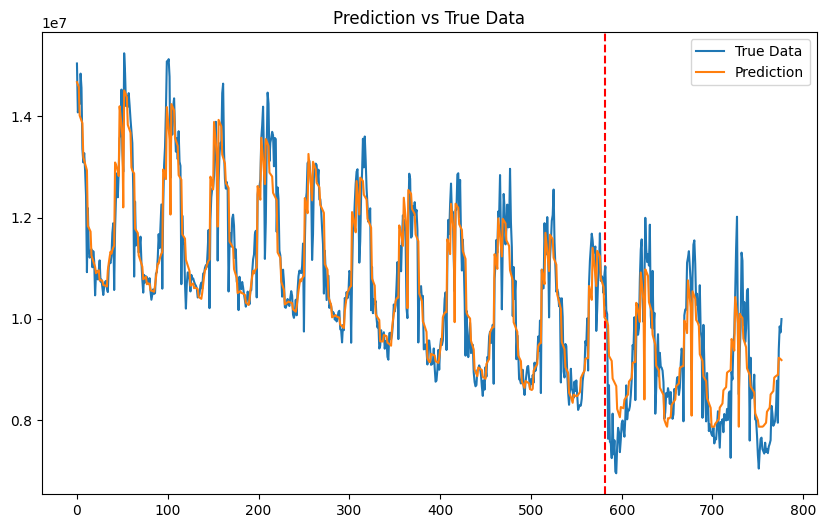

In [ ]:
df_features_ss = ss.transform(weekly_summed_national_demand_lstm.iloc[:, :-1])
df_target_mm = mm.transform(weekly_summed_national_demand_lstm.iloc[:, -1:])

df_features_ss = Variable(torch.Tensor(df_features_ss))
df_target_mm = Variable(torch.Tensor(df_target_mm))

# reshaping the dataset
df_features_ss = torch.reshape(df_features_ss, (df_features_ss.shape[0], 1, df_features_ss.shape[1]))
print("Test data shape: ", df_features_ss.shape)

train_predict = lstm(df_features_ss) #foward pass
data_predict = train_predict.data.numpy()
data_y_plot = df_target_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
data_y_plot = mm.inverse_transform(data_y_plot)

plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(data_y_plot, label='True Data')
plt.plot(data_predict, label='Prediction')
plt.title('Prediction vs True Data')
plt.legend()
plt.show()

In [ ]:
# Pass the test features through the trained LSTM model
test_predict = lstm(features_test_tensors_final)

# Convert the predicted values and target test values to their original scales
test_predict = mm.inverse_transform(test_predict.data.numpy())
target_test = mm.inverse_transform(target_test_tensors.data.numpy())

# Calculate evaluation metrics
mse = mean_squared_error(target_test, test_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(target_test, test_predict)
mape = mean_absolute_percentage_error(target_test, test_predict)

# Print or display the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE): ", mape)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 576018.9
Mean Absolute Percentage Error (MAPE):  0.0657056
Mean Squared Error (MSE): 531669120000.0
Root Mean Squared Error (RMSE): 729156.44


In [ ]:
# get the last 5 weeks of data for original and predicted
last_5_weeks_orig = weekly_summed_national_demand_lstm.tail(5)["weekly_summed_national_demand"].to_list()
last_5_weeks_predicted = test_predict[-5:].flatten().tolist()

print("Last 5 weeks of original data: ", last_5_weeks_orig)
print("Last 5 weeks of predicted data: ", last_5_weeks_predicted)


Last 5 weeks of original data:  [7947981, 9395589, 9851889, 9733451, 9996301]
Last 5 weeks of predicted data:  [8890522.0, 9231389.0, 9219268.0, 9203999.0, 9185752.0]


In [ ]:
# find the rmse for the last 5 weeks
last_5_weeks_rmse = np.sqrt(mean_squared_error(last_5_weeks_orig, last_5_weeks_predicted))
last_5_weeks_mape = mean_absolute_percentage_error(last_5_weeks_orig, last_5_weeks_predicted)

print("MAPE for last 5 weeks: ", last_5_weeks_mape)
print("RMSE for last 5 weeks: ", last_5_weeks_rmse)

MAPE for last 5 weeks:  0.0671516352302894
RMSE for last 5 weeks:  671247.1389923387


In [ ]:
torch.manual_seed(111)

def create_tensor(weekly_summed_national_demand_lstm: pd.DataFrame):
  features = weekly_summed_national_demand_lstm.iloc[:, :-1]
  target = weekly_summed_national_demand_lstm.iloc[:, 5:6]

  features_ss = ss.fit_transform(features)
  target_mm = mm.fit_transform(target)

  features_train, features_test = features_ss[0:train_size,:], features_ss[train_size:len(features),:]
  target_train, target_test = target_mm[0:train_size,:], target_mm[train_size:len(features),:]

  features_train_tensors = Variable(torch.Tensor(features_train))
  features_test_tensors = Variable(torch.Tensor(features_test))

  target_train_tensors = Variable(torch.Tensor(target_train))
  target_test_tensors = Variable(torch.Tensor(target_test))

  # reshaping to rows, timestamps, features
  features_train_tensors_final = torch.reshape(features_train_tensors, (features_train_tensors.shape[0], 1, features_train_tensors.shape[1]))
  features_test_tensors_final = torch.reshape(features_test_tensors, (features_test_tensors.shape[0], 1, features_test_tensors.shape[1]))

  return features_train_tensors_final, features_test_tensors_final, target_train_tensors, target_test_tensors

In [ ]:
torch.manual_seed(111)

# grid search params
params = {
  'num_classes': [1],
  'input_size': [5],
  'hidden_size': [2],
  'num_layers': [1],
  'num_epochs': [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500],
  'learning_rate': [0.001, 0.003, 0.005, 0.007, 0.009, 0.01],
  'output_features': [16, 32, 64, 128, 256, 512]
}

# create tensor
features_train_tensors_final, features_test_tensors_final, target_train_tensors, target_test_tensors = create_tensor(weekly_summed_national_demand_lstm)

# create the model
lstm = LSTMModel(num_classes, input_size, hidden_size, num_layers, num_epochs, learning_rate, output_features)

# create the grid search
clf = GridSearchCV(lstm, params, n_jobs=-1, verbose=1)
clf.fit(features_train_tensors_final, target_train_tensors)

# print the best params
print("Best params: ", clf.best_params_)
print("Best score: ", clf.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Running with params:  {'num_classes': 1, 'input_size': 5, 'hidden_size': 2, 'num_layers': 1, 'num_epochs': 3500, 'learning_rate': 0.007, 'output_features': 128}
Epoch: 3499, loss: 0.00311
Best params:  {'hidden_size': 2, 'input_size': 5, 'learning_rate': 0.007, 'num_classes': 1, 'num_epochs': 3500, 'num_layers': 1, 'output_features': 128}
Best score:  0.18199776709079743


In [ ]:
torch.manual_seed(111)

num_epochs = 3500
learning_rate = 0.007
output_features = 128
hidden_size = 2
num_classes = 1
input_size = 5

# create tensor
features_train_tensors_final, features_test_tensors_final, target_train_tensors, target_test_tensors = create_tensor(weekly_summed_national_demand_lstm)

# create model
lstm = LSTMModel(num_classes, input_size, hidden_size, num_layers, num_epochs, learning_rate, output_features)
lstm.fit(features_train_tensors_final, target_train_tensors)

Running with params:  {'num_classes': 1, 'input_size': 5, 'hidden_size': 2, 'num_layers': 1, 'num_epochs': 3500, 'learning_rate': 0.007, 'output_features': 128}
Epoch: 3499, loss: 0.00338


Test data shape:  torch.Size([777, 1, 5])


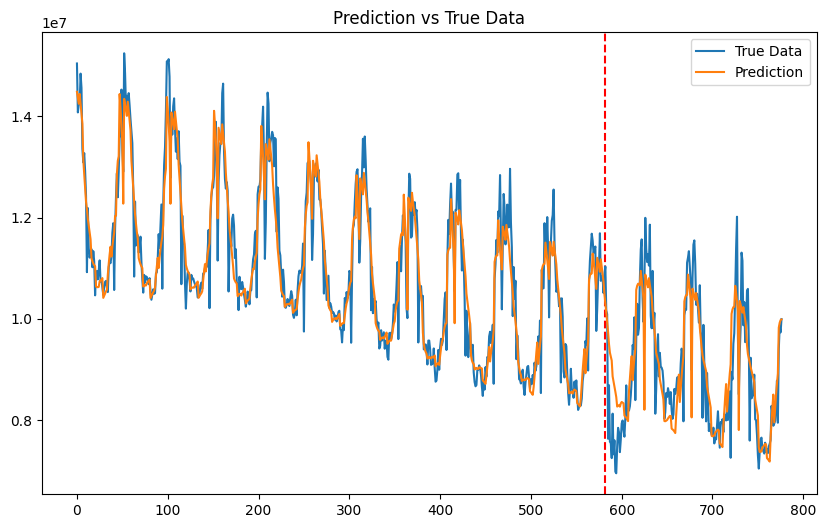

In [ ]:
df_features_ss = ss.transform(weekly_summed_national_demand_lstm.iloc[:, :-1])
df_target_mm = mm.transform(weekly_summed_national_demand_lstm.iloc[:, -1:])

df_features_ss = Variable(torch.Tensor(df_features_ss))
df_target_mm = Variable(torch.Tensor(df_target_mm))

# reshaping the dataset
df_features_ss = torch.reshape(df_features_ss, (df_features_ss.shape[0], 1, df_features_ss.shape[1]))
print("Test data shape: ", df_features_ss.shape)

train_predict = lstm(df_features_ss) #foward pass
data_predict = train_predict.data.numpy()
data_y_plot = df_target_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
data_y_plot = mm.inverse_transform(data_y_plot)

plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(data_y_plot, label='True Data')
plt.plot(data_predict, label='Prediction')
plt.title('Prediction vs True Data')
plt.legend()
plt.show()

In [ ]:
# Pass the test features through the trained LSTM model
test_predict = lstm(features_test_tensors_final)

# Convert the predicted values and target test values to their original scales
test_predict = mm.inverse_transform(test_predict.data.numpy())
target_test = mm.inverse_transform(target_test_tensors.data.numpy())

# Calculate evaluation metrics
mse = mean_squared_error(target_test, test_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(target_test, test_predict)
mape = mean_absolute_percentage_error(target_test, test_predict)

# Print or display the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAE):", mape)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 527496.75
Mean Absolute Percentage Error (MAE): 0.059992276
Mean Squared Error (MSE): 477821860000.0
Root Mean Squared Error (RMSE): 691246.6


In [ ]:
# get the last 5 weeks of data for original and predicted
last_5_weeks_orig = weekly_summed_national_demand_lstm.tail(5)["weekly_summed_national_demand"].to_list()
last_5_weeks_predicted = test_predict[-5:].flatten().tolist()

print("Last 5 weeks of original data: ", last_5_weeks_orig)
print("Last 5 weeks of predicted data: ", last_5_weeks_predicted)

Last 5 weeks of original data:  [7947981, 9395589, 9851889, 9733451, 9996301]
Last 5 weeks of predicted data:  [8919113.0, 9826719.0, 9923261.0, 9976425.0, 9989064.0]


In [ ]:
# find the rmse for the last 5 weeks
last_5_weeks_rmse = np.sqrt(mean_squared_error(last_5_weeks_orig, last_5_weeks_predicted))
last_5_weeks_mape = mean_absolute_percentage_error(last_5_weeks_orig, last_5_weeks_predicted)

print("MAPE for last 5 weeks: ", last_5_weeks_mape)
print("RMSE for last 5 weeks: ", last_5_weeks_rmse)

MAPE for last 5 weeks:  0.04020073449270118
RMSE for last 5 weeks:  488498.3397214365
